In [32]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

tf.reset_default_graph()

# np.random.seed(111)
# tf.set_random_seed(111)


In [33]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


In [34]:
#True model

sphere_center = 300. #m 
density_difference = 500. # kg/m^3: density diffrence to surrounding domain
sphere_radius = 100. #m

x_domain=np.linspace(-1000,1000,101) #m

In [35]:
# x_obs = 0
x_obs = np.linspace(-250, 250, 11)
grav_all = grav_analytical(x_domain, sphere_center, sphere_radius, density_difference)
grav_obs_array = grav_analytical(x_obs, sphere_center, sphere_radius, density_difference)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_withnoise = grav_obs_array +noise
grav_obs_array_noise_sum = np.sum(grav_obs_array_withnoise)

In [36]:
grav_obs_array_noise_sum

1.3026348996764288

In [37]:
grav_obs_array_withnoise,

(array([0.08130283, 0.12081211, 0.11001469, 0.12486764, 0.15498966,
        0.16815919, 0.14640062, 0.1198276 , 0.11531002, 0.08539004,
        0.0755605 ]),)

In [38]:
noise_variance = np.std(noise)

noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)

noise_tensor = tf.diag(noise_1)

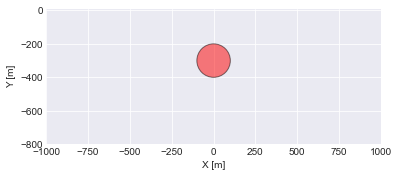

In [39]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center), sphere_radius, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.savefig('./Simple_grav_img/SG_noise_3_para/model.png')

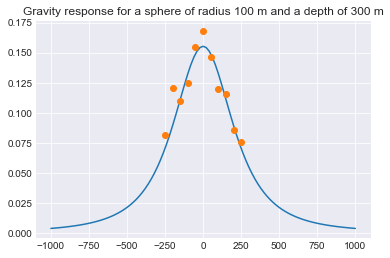

In [40]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_withnoise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");
plt.savefig('./Simple_grav_img/SG_noise_3_para/gravity.png')

### NEW

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [41]:
mu_prior = [280., 450., 80.]
mu_prior = tf.convert_to_tensor(mu_prior)

cov = [[ 400.,  0.,  0.],
        [ 0.,  400., 0.],
        [ 0., 0.,  400.]]
cov = tf.convert_to_tensor(cov)

The likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [42]:
## initial guess

mu = tf.get_variable("mu", dtype=tf.float32,
  initializer=tf.constant([280., 470., 120.]))
# true = [300., 500., 100.]


In [43]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.

def grav_analytical_tf(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = tf.reduce_sum(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ,keepdims=True)

    
    return gravity



### Gradient decent to find MAP (?)

In [44]:
import tensorflow.math as tm

## function compute G^T C^-1 G

def matrixcompute(matrix1,matrix2,Cov):
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    
    return result

In [45]:
### debug!!! 

mu1 = tf.get_variable("mu1", dtype=tf.float32,
  initializer=tf.constant([500., 100., 50.]))

mu2 = tf.get_variable("mu2", dtype=tf.float32,
  initializer=tf.constant([310., 500., 100.]))


grav1 = grav_analytical_tf(x_obs,mu1, cov)
grav2 = grav_analytical_tf(x_obs,mu2, cov)


f_m1 = matrixcompute(grav1,grav_obs_array_noise_sum,noise_tensor)
f_m2 = matrixcompute(grav2,grav_obs_array_noise_sum,noise_tensor)

In [54]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(f_m1))
    print(sess.run(MAP))

[[74.1186]]
[292.6129  459.29068  88.74929]


\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

In [12]:
grav_obs_array_noise_sum = tf.convert_to_tensor(grav_obs_array_noise_sum,dtype=tf.float32)

term 2
\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [52]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    grav = grav_analytical_tf(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_noise_sum,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    Negtive_log_likelihood = tf.add(term_1,term_2)
    
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(Negtive_log_likelihood)
    log_tem = session.run(Negtive_log_likelihood) 
    
    print("starting at", "mu:", session.run(mu), "negative log likelihood:", session.run(Negtive_log_likelihood))
    for step in range(100000):  
        session.run(train)
        log_tem_new = session.run(Negtive_log_likelihood)
       ## Find and save MAP point 
        if log_tem_new < log_tem:
            log_tem = log_tem_new
            MAP = session.run(mu)
        
        if step%10 == 0: print("step", step, "mu:", session.run(mu), "negative log likelihood:",log_tem_new )

    

starting at mu: [280. 470. 120.] negative log likelihood: [[83.09925]]
step 0 mu: [280.00156 469.99887 119.99077] negative log likelihood: [[29.727573]]
step 10 mu: [280.25302 469.89676 119.02341] negative log likelihood: [[89.1284]]
step 20 mu: [280.53094 469.7843  117.97993] negative log likelihood: [[88.77684]]
step 30 mu: [280.67874 469.7215  117.35926] negative log likelihood: [[212.6373]]
step 40 mu: [280.92676 469.62555 116.46308] negative log likelihood: [[22.898468]]
step 50 mu: [281.0886  469.5583  115.81267] negative log likelihood: [[37.600163]]
step 60 mu: [281.23212 469.49817 115.22853] negative log likelihood: [[233.16974]]
step 70 mu: [281.54276 469.37372 114.06516] negative log likelihood: [[28.38221]]
step 80 mu: [281.59674 469.34778 113.81727] negative log likelihood: [[21.193987]]
step 90 mu: [281.6708  469.31262 113.48964] negative log likelihood: [[42.523293]]
step 100 mu: [281.83557  469.24597  112.854095] negative log likelihood: [[21.75268]]
step 110 mu: [282.0

step 1100 mu: [286.63095 466.8801   93.98189] negative log likelihood: [[17.650883]]
step 1110 mu: [286.62292  466.87888   94.043785] negative log likelihood: [[33.131783]]
step 1120 mu: [286.61465  466.8773    94.095215] negative log likelihood: [[24.850758]]
step 1130 mu: [286.6317  466.8656   94.02149] negative log likelihood: [[16.742403]]
step 1140 mu: [286.74026  466.82016   93.655174] negative log likelihood: [[28.081945]]
step 1150 mu: [286.74176 466.81448  93.66096] negative log likelihood: [[0.8613024]]
step 1160 mu: [286.77686  466.79337   93.536285] negative log likelihood: [[10.370846]]
step 1170 mu: [286.77106  466.79083   93.579704] negative log likelihood: [[0.8830906]]
step 1180 mu: [286.77713 466.78345  93.57701] negative log likelihood: [[4.1180434]]
step 1190 mu: [286.79904 466.77042  93.47779] negative log likelihood: [[9.368759]]
step 1200 mu: [286.81464  466.7586    93.418846] negative log likelihood: [[12.255123]]
step 1210 mu: [286.82806 466.74854  93.36804] ne

step 2240 mu: [287.89435  465.8517    90.243324] negative log likelihood: [[3.4289641]]
step 2250 mu: [287.90598 465.84247  90.20038] negative log likelihood: [[3.3633137]]
step 2260 mu: [287.9073   465.83704   90.195045] negative log likelihood: [[47.319954]]
step 2270 mu: [287.9155   465.82892   90.171715] negative log likelihood: [[15.414269]]
step 2280 mu: [287.94415 465.81268  90.07098] negative log likelihood: [[74.988464]]
step 2290 mu: [287.93564 465.8115   90.12905] negative log likelihood: [[0.7088489]]
step 2300 mu: [287.93723 465.80643  90.13582] negative log likelihood: [[0.60446715]]
step 2310 mu: [287.92935 465.80508  90.19435] negative log likelihood: [[21.356369]]
step 2320 mu: [287.935   465.7983   90.16868] negative log likelihood: [[19.976885]]
step 2330 mu: [287.9648  465.78067  90.06032] negative log likelihood: [[5.0663977]]
step 2340 mu: [287.97324 465.77228  90.03985] negative log likelihood: [[37.985863]]
step 2350 mu: [287.9796  465.7651   90.02038] negative 

step 3290 mu: [288.53064 465.12527  89.15494] negative log likelihood: [[56.99175]]
step 3300 mu: [288.52374 465.12344  89.2007 ] negative log likelihood: [[64.12436]]
step 3310 mu: [288.50912 465.12494  89.29106] negative log likelihood: [[16.01449]]
step 3320 mu: [288.52103  465.11578   89.232086] negative log likelihood: [[9.221546]]
step 3330 mu: [288.54703 465.10117  89.13549] negative log likelihood: [[1.0852559]]
step 3340 mu: [288.54544  465.09726   89.160194] negative log likelihood: [[43.98783]]
step 3350 mu: [288.5452  465.09268  89.16944] negative log likelihood: [[2.2548227]]
step 3360 mu: [288.53653 465.09146  89.23096] negative log likelihood: [[21.754107]]
step 3370 mu: [288.57782 465.0708   89.08325] negative log likelihood: [[48.276005]]
step 3380 mu: [288.5651  465.07147  89.16504] negative log likelihood: [[2.6962872]]
step 3390 mu: [288.56375  465.06735   89.191864] negative log likelihood: [[16.418093]]
step 3400 mu: [288.5674  465.06146  89.17995] negative log li

step 4400 mu: [289.31027 464.3254   87.75208] negative log likelihood: [[33.21979]]
step 4410 mu: [289.30487 464.32315  87.79678] negative log likelihood: [[14.73818]]
step 4420 mu: [289.29346  464.32336   87.862976] negative log likelihood: [[8.057694]]
step 4430 mu: [289.30243 464.31537  87.83558] negative log likelihood: [[30.658709]]
step 4440 mu: [289.30685 464.30933  87.82658] negative log likelihood: [[10.065363]]
step 4450 mu: [289.28836 464.31238  87.94042] negative log likelihood: [[60.2952]]
step 4460 mu: [289.27594  464.3129    88.014854] negative log likelihood: [[42.31216]]
step 4470 mu: [289.33313  464.28384   87.850685] negative log likelihood: [[0.44552594]]
step 4480 mu: [289.32935 464.28094  87.87269] negative log likelihood: [[23.37299]]
step 4490 mu: [289.33652 464.2742   87.85213] negative log likelihood: [[29.603733]]
step 4500 mu: [289.33746 464.26965  87.87495] negative log likelihood: [[21.690973]]
step 4510 mu: [289.3661   464.2533    87.749596] negative log 

step 5530 mu: [289.55304  463.74365   88.778854] negative log likelihood: [[17.092136]]
step 5540 mu: [289.53674 463.746    88.88019] negative log likelihood: [[18.503164]]
step 5550 mu: [289.52524 463.74643  88.94836] negative log likelihood: [[10.099518]]
step 5560 mu: [289.58707 463.71927  88.69539] negative log likelihood: [[42.934998]]
step 5570 mu: [289.59094 463.7138   88.70117] negative log likelihood: [[43.46072]]
step 5580 mu: [289.59677  463.70712   88.678986] negative log likelihood: [[1.3539668]]
step 5590 mu: [289.57974  463.70947   88.774284] negative log likelihood: [[8.441628]]
step 5600 mu: [289.67084 463.67014  88.48731] negative log likelihood: [[3.5640488]]
step 5610 mu: [289.67462 463.66415  88.48116] negative log likelihood: [[23.790373]]
step 5620 mu: [289.68146 463.6566   88.4518 ] negative log likelihood: [[0.6327342]]
step 5630 mu: [289.673    463.65552   88.503944] negative log likelihood: [[13.001356]]
step 5640 mu: [289.67612 463.64975  88.50925] negative 

step 6670 mu: [289.98834 463.09552  88.96782] negative log likelihood: [[1.3383318]]
step 6680 mu: [289.97934 463.09464  89.01975] negative log likelihood: [[6.84389]]
step 6690 mu: [289.9945  463.08414  88.95986] negative log likelihood: [[5.335019]]
step 6700 mu: [290.00165 463.0772   88.94889] negative log likelihood: [[22.263693]]
step 6710 mu: [290.03745 463.0595   88.83735] negative log likelihood: [[0.48584765]]
step 6720 mu: [290.02792  463.05902   88.889275] negative log likelihood: [[69.73375]]
step 6730 mu: [290.04532 463.04724  88.81771] negative log likelihood: [[12.70487]]
step 6740 mu: [290.0427  463.04382  88.83816] negative log likelihood: [[41.446922]]
step 6750 mu: [290.09323  463.0194    88.633385] negative log likelihood: [[7.8200965]]
step 6760 mu: [290.09592 463.01398  88.63205] negative log likelihood: [[44.743793]]
step 6770 mu: [290.08508 463.0141   88.70044] negative log likelihood: [[11.929044]]
step 6780 mu: [290.07617 463.01367  88.75355] negative log like

step 7800 mu: [290.44482 462.45966  89.04873] negative log likelihood: [[40.829704]]
step 7810 mu: [290.42584 462.463    89.16284] negative log likelihood: [[34.064327]]
step 7820 mu: [290.4238  462.45963  89.18684] negative log likelihood: [[34.735477]]
step 7830 mu: [290.4398  462.44858  89.12632] negative log likelihood: [[41.44909]]
step 7840 mu: [290.53378 462.41046  88.78142] negative log likelihood: [[7.5611167]]
step 7850 mu: [290.5558   462.39877   88.692764] negative log likelihood: [[41.420284]]
step 7860 mu: [290.56262 462.3923   88.67116] negative log likelihood: [[49.188828]]
step 7870 mu: [290.5531  462.39218  88.73413] negative log likelihood: [[59.58205]]
step 7880 mu: [290.5628  462.38428  88.68485] negative log likelihood: [[0.43210694]]
step 7890 mu: [290.5656  462.3784   88.69347] negative log likelihood: [[29.755997]]
step 7900 mu: [290.58127 462.36804  88.64707] negative log likelihood: [[6.1688395]]
step 7910 mu: [290.56635 462.3699   88.74344] negative log like

step 8960 mu: [290.96402 461.80005  88.80779] negative log likelihood: [[57.981503]]
step 8970 mu: [290.98218 461.7887   88.72649] negative log likelihood: [[7.0346]]
step 8980 mu: [290.96542 461.79153  88.82642] negative log likelihood: [[28.673643]]
step 8990 mu: [290.96594 461.78757  88.82838] negative log likelihood: [[0.6738454]]
step 9000 mu: [290.9935   461.7727    88.726204] negative log likelihood: [[16.058857]]
step 9010 mu: [290.97992  461.77417   88.824135] negative log likelihood: [[6.0293355]]
step 9020 mu: [290.99045  461.76697   88.794266] negative log likelihood: [[19.624035]]
step 9030 mu: [290.99094 461.76282  88.80295] negative log likelihood: [[2.8337188]]
step 9040 mu: [290.98233 461.76236  88.86736] negative log likelihood: [[4.0137186]]
step 9050 mu: [290.98364 461.75818  88.88482] negative log likelihood: [[1.2561171]]
step 9060 mu: [290.978   461.7567   88.93538] negative log likelihood: [[3.5317807]]
step 9070 mu: [290.97754 461.75317  88.94999] negative log 

step 10060 mu: [291.20102 461.28528  89.60226] negative log likelihood: [[15.258374]]
step 10070 mu: [291.2113   461.27817   89.590294] negative log likelihood: [[40.999638]]
step 10080 mu: [291.2179  461.27115  89.56169] negative log likelihood: [[9.767599]]
step 10090 mu: [291.2078   461.271     89.634636] negative log likelihood: [[14.917085]]
step 10100 mu: [291.223   461.2613   89.57493] negative log likelihood: [[46.74992]]
step 10110 mu: [291.21927 461.25888  89.61329] negative log likelihood: [[14.654771]]
step 10120 mu: [291.21616 461.25632  89.63112] negative log likelihood: [[71.1487]]
step 10130 mu: [291.21924  461.25146   89.628105] negative log likelihood: [[2.4064054]]
step 10140 mu: [291.20972 461.2516   89.68372] negative log likelihood: [[0.55876213]]
step 10150 mu: [291.24814 461.23303  89.53572] negative log likelihood: [[28.679525]]
step 10160 mu: [291.2362  461.23395  89.60742] negative log likelihood: [[19.690598]]
step 10170 mu: [291.2432  461.22684  89.58027] n

step 11170 mu: [291.34763 460.8015   90.54038] negative log likelihood: [[35.80091]]
step 11180 mu: [291.36533 460.79178  90.47136] negative log likelihood: [[6.0085287]]
step 11190 mu: [291.3853   460.77994   90.381096] negative log likelihood: [[8.966751]]
step 11200 mu: [291.36954  460.78262   90.467384] negative log likelihood: [[29.640133]]
step 11210 mu: [291.36514  460.7804    90.488754] negative log likelihood: [[27.28375]]
step 11220 mu: [291.41763 460.75565  90.26204] negative log likelihood: [[1.5940588]]
step 11230 mu: [291.41647  460.7524    90.267006] negative log likelihood: [[20.840601]]
step 11240 mu: [291.41217 460.75024  90.29397] negative log likelihood: [[11.839885]]
step 11250 mu: [291.47083 460.72467  90.03464] negative log likelihood: [[6.5546355]]
step 11260 mu: [291.47342 460.72046  90.03097] negative log likelihood: [[5.658506]]
step 11270 mu: [291.46912  460.71863   90.057846] negative log likelihood: [[40.62821]]
step 11280 mu: [291.46677 460.71585  90.0760

step 12260 mu: [291.89426  460.18542   89.574905] negative log likelihood: [[0.50924885]]
step 12270 mu: [291.90555  460.17673   89.535576] negative log likelihood: [[46.366425]]
step 12280 mu: [291.90408  460.1738    89.543434] negative log likelihood: [[32.876846]]
step 12290 mu: [291.91266 460.1669   89.51523] negative log likelihood: [[2.0457826]]
step 12300 mu: [291.90988 460.1642   89.54587] negative log likelihood: [[0.5039506]]
step 12310 mu: [291.8972  460.16583  89.6267 ] negative log likelihood: [[0.5950488]]
step 12320 mu: [291.88586  460.16675   89.691956] negative log likelihood: [[45.961136]]
step 12330 mu: [291.91394 460.15094  89.59894] negative log likelihood: [[0.4378903]]
step 12340 mu: [291.91315 460.14792  89.61443] negative log likelihood: [[15.379827]]
step 12350 mu: [291.91354 460.1438   89.61553] negative log likelihood: [[3.2615643]]
step 12360 mu: [291.90955 460.142    89.64278] negative log likelihood: [[0.4359813]]
step 12370 mu: [291.9048   460.14023   89

step 13340 mu: [292.44     459.57773   88.740715] negative log likelihood: [[1.2703042]]
step 13350 mu: [292.4317 459.5775  88.7863] negative log likelihood: [[0.544552]]
step 13360 mu: [292.42245  459.57764   88.839355] negative log likelihood: [[30.854944]]
step 13370 mu: [292.41977 459.57504  88.86278] negative log likelihood: [[2.817796]]
step 13380 mu: [292.408   459.5765   88.92678] negative log likelihood: [[50.3423]]
step 13390 mu: [292.39114 459.57983  89.03015] negative log likelihood: [[8.788437]]
step 13400 mu: [292.39334 459.57483  89.02798] negative log likelihood: [[4.222531]]
step 13410 mu: [292.38345  459.5753    89.088356] negative log likelihood: [[4.3823395]]
step 13420 mu: [292.3688  459.57764  89.17669] negative log likelihood: [[24.939653]]
step 13430 mu: [292.3944   459.56406   89.074066] negative log likelihood: [[33.054535]]
step 13440 mu: [292.38376 459.5649   89.13764] negative log likelihood: [[1.1584508]]
step 13450 mu: [292.38034 459.5629   89.1458 ] nega

step 14390 mu: [292.55286 459.1611   89.65208] negative log likelihood: [[78.31447]]
step 14400 mu: [292.5481  459.15985  89.68493] negative log likelihood: [[21.75843]]
step 14410 mu: [292.53387 459.1622   89.76376] negative log likelihood: [[5.4299726]]
step 14420 mu: [292.57794  459.14102   89.607346] negative log likelihood: [[29.891006]]
step 14430 mu: [292.57834  459.1373    89.613686] negative log likelihood: [[12.058867]]
step 14440 mu: [292.5767  459.13437  89.62836] negative log likelihood: [[6.491123]]
step 14450 mu: [292.56412 459.1363   89.69822] negative log likelihood: [[36.686436]]
step 14460 mu: [292.55685 459.13556  89.73407] negative log likelihood: [[50.283813]]
step 14470 mu: [292.5507  459.13446  89.76831] negative log likelihood: [[24.388178]]
step 14480 mu: [292.55417  459.1292    89.766655] negative log likelihood: [[25.340103]]
step 14490 mu: [292.53992 459.13168  89.84575] negative log likelihood: [[196.96498]]
step 14500 mu: [292.563    459.11716   89.758766

step 15360 mu: [292.72455 458.76227  90.30103] negative log likelihood: [[6.4678445]]
step 15370 mu: [292.7474  458.75     90.20219] negative log likelihood: [[44.945786]]
step 15380 mu: [292.74075 458.7489   90.24584] negative log likelihood: [[48.296944]]
step 15390 mu: [292.7768   458.731     90.066605] negative log likelihood: [[50.8225]]
step 15400 mu: [292.76636 458.73215  90.12134] negative log likelihood: [[54.10072]]
step 15410 mu: [292.81427 458.70883  89.92211] negative log likelihood: [[25.589832]]
step 15420 mu: [292.82715 458.69925  89.89134] negative log likelihood: [[45.202587]]
step 15430 mu: [292.818   458.69952  89.94843] negative log likelihood: [[69.74498]]
step 15440 mu: [292.8136   458.69763   89.971886] negative log likelihood: [[31.765982]]
step 15450 mu: [292.8139   458.6941    89.983574] negative log likelihood: [[7.003042]]
step 15460 mu: [292.80707 458.6936   90.02292] negative log likelihood: [[17.788725]]
step 15470 mu: [292.81216 458.68848  90.01866] neg

step 16360 mu: [292.92947  458.3508    90.642815] negative log likelihood: [[18.920845]]
step 16370 mu: [292.91675  458.35266   90.707306] negative log likelihood: [[1.0851238]]
step 16380 mu: [292.9078  458.35306  90.7499 ] negative log likelihood: [[10.455852]]
step 16390 mu: [292.89517 458.3549   90.82552] negative log likelihood: [[6.7809896]]
step 16400 mu: [292.88705 458.35483  90.87203] negative log likelihood: [[0.4427165]]
step 16410 mu: [292.9773   458.31372   90.552765] negative log likelihood: [[12.41615]]
step 16420 mu: [292.9825  458.30878  90.52155] negative log likelihood: [[51.40721]]
step 16430 mu: [292.9953   458.30002   90.476616] negative log likelihood: [[18.851631]]
step 16440 mu: [293.00873 458.29138  90.40812] negative log likelihood: [[27.441805]]
step 16450 mu: [293.09225 458.25552  90.07004] negative log likelihood: [[14.46614]]
step 16460 mu: [293.0781   458.2582    90.150566] negative log likelihood: [[54.633785]]
step 16470 mu: [293.07562 458.25595  90.16

step 17520 mu: [293.54715 457.72455  89.67219] negative log likelihood: [[4.7990837]]
step 17530 mu: [293.54575 457.72217  89.68682] negative log likelihood: [[0.4219069]]
step 17540 mu: [293.54193 457.7205   89.70829] negative log likelihood: [[53.63942]]
step 17550 mu: [293.5802  457.70242  89.54506] negative log likelihood: [[19.797604]]
step 17560 mu: [293.5832  457.69833  89.54358] negative log likelihood: [[12.780246]]
step 17570 mu: [293.6106   457.68445   89.438255] negative log likelihood: [[0.5800315]]
step 17580 mu: [293.60477 457.68405  89.46843] negative log likelihood: [[3.7091534]]
step 17590 mu: [293.60635  457.68      89.471245] negative log likelihood: [[1.0248678]]
step 17600 mu: [293.6014  457.67847  89.49607] negative log likelihood: [[35.95987]]
step 17610 mu: [293.59943 457.67575  89.53001] negative log likelihood: [[28.771473]]
step 17620 mu: [293.59366 457.67505  89.5709 ] negative log likelihood: [[65.23206]]
step 17630 mu: [293.58957 457.67303  89.60307] nega

step 18470 mu: [293.76993  457.33792   89.808556] negative log likelihood: [[2.6368573]]
step 18480 mu: [293.81525 457.31833  89.63609] negative log likelihood: [[29.272003]]
step 18490 mu: [293.79443 457.3238   89.7654 ] negative log likelihood: [[24.443665]]
step 18500 mu: [293.80173 457.31793  89.76144] negative log likelihood: [[29.5481]]
step 18510 mu: [293.7952  457.3176   89.79012] negative log likelihood: [[5.259893]]
step 18520 mu: [293.8036  457.3114   89.76108] negative log likelihood: [[2.4304414]]
step 18530 mu: [293.81027  457.30594   89.734695] negative log likelihood: [[1.8474948]]
step 18540 mu: [293.81656  457.30096   89.707985] negative log likelihood: [[3.2771616]]
step 18550 mu: [293.80432  457.30283   89.769135] negative log likelihood: [[1.8549697]]
step 18560 mu: [293.80066  457.301     89.781456] negative log likelihood: [[50.53978]]
step 18570 mu: [293.7919  457.30127  89.82283] negative log likelihood: [[0.42580462]]
step 18580 mu: [293.77484 457.30536  89.92

step 19470 mu: [293.9353   456.9616    90.276596] negative log likelihood: [[42.102448]]
step 19480 mu: [293.94315 456.95496  90.24612] negative log likelihood: [[10.0816765]]
step 19490 mu: [293.9401   456.95306   90.269485] negative log likelihood: [[8.6645]]
step 19500 mu: [293.94345 456.949    90.26485] negative log likelihood: [[32.597317]]
step 19510 mu: [293.93573  456.94913   90.302216] negative log likelihood: [[30.44649]]
step 19520 mu: [293.93094 456.948    90.32484] negative log likelihood: [[0.44636118]]
step 19530 mu: [293.95258  456.93524   90.233025] negative log likelihood: [[51.08343]]
step 19540 mu: [294.01077 456.9096   90.01502] negative log likelihood: [[42.58938]]
step 19550 mu: [293.99448  456.91336   90.101746] negative log likelihood: [[63.77616]]
step 19560 mu: [294.04736 456.88892  89.90141] negative log likelihood: [[12.017975]]
step 19570 mu: [294.05832 456.88086  89.84474] negative log likelihood: [[21.742159]]
step 19580 mu: [294.0542  456.87955  89.8774

step 20510 mu: [294.35715  456.4775    89.450905] negative log likelihood: [[94.005615]]
step 20520 mu: [294.40555 456.45493  89.24191] negative log likelihood: [[49.40369]]
step 20530 mu: [294.4118   456.45      89.211075] negative log likelihood: [[1.0399661]]
step 20540 mu: [294.40222 456.45087  89.27027] negative log likelihood: [[21.152346]]
step 20550 mu: [294.3902  456.45242  89.33178] negative log likelihood: [[11.71048]]
step 20560 mu: [294.401   456.44553  89.28537] negative log likelihood: [[27.411465]]
step 20570 mu: [294.41495 456.4373   89.21842] negative log likelihood: [[32.55807]]
step 20580 mu: [294.4078   456.437     89.265755] negative log likelihood: [[12.438712]]
step 20590 mu: [294.39597 456.43875  89.33692] negative log likelihood: [[71.00067]]
step 20600 mu: [294.38507 456.4403   89.39988] negative log likelihood: [[416.7625]]
step 20610 mu: [294.39944 456.4316   89.32146] negative log likelihood: [[9.488562]]
step 20620 mu: [294.39185 456.43164  89.36293] nega

step 21620 mu: [294.53925  456.0775    89.889046] negative log likelihood: [[45.390003]]
step 21630 mu: [294.53     456.07822   89.951065] negative log likelihood: [[0.69227207]]
step 21640 mu: [294.53558 456.07343  89.92255] negative log likelihood: [[13.23691]]
step 21650 mu: [294.51727  456.07794   90.027145] negative log likelihood: [[20.94262]]
step 21660 mu: [294.5251   456.07175   89.985565] negative log likelihood: [[52.83367]]
step 21670 mu: [294.51492 456.07297  90.03545] negative log likelihood: [[21.000706]]
step 21680 mu: [294.59396 456.0394   89.75107] negative log likelihood: [[16.581877]]
step 21690 mu: [294.58206 456.04147  89.82498] negative log likelihood: [[7.122846]]
step 21700 mu: [294.5681  456.0443   89.90478] negative log likelihood: [[39.50281]]
step 21710 mu: [294.5579  456.0457   89.96229] negative log likelihood: [[2.1337395]]
step 21720 mu: [294.5388  456.05057  90.07368] negative log likelihood: [[26.186653]]
step 21730 mu: [294.54932 456.04352  90.02467]

step 22750 mu: [294.7238   455.68457   90.252975] negative log likelihood: [[3.2353108]]
step 22760 mu: [294.71774 455.68436  90.2831 ] negative log likelihood: [[2.2287345]]
step 22770 mu: [294.72052 455.6805   90.28164] negative log likelihood: [[0.73893]]
step 22780 mu: [294.70422  455.6842    90.367386] negative log likelihood: [[14.539291]]
step 22790 mu: [294.7233  455.67334  90.27889] negative log likelihood: [[6.712447]]
step 22800 mu: [294.72266 455.67084  90.27865] negative log likelihood: [[10.796128]]
step 22810 mu: [294.7209  455.66873  90.28471] negative log likelihood: [[7.320407]]
step 22820 mu: [294.7026  455.6735   90.38649] negative log likelihood: [[1.7069483]]
step 22830 mu: [294.71143 455.66696  90.35838] negative log likelihood: [[102.29646]]
step 22840 mu: [294.70496  455.66663   90.392525] negative log likelihood: [[18.751877]]
step 22850 mu: [294.71063 455.66132  90.35724] negative log likelihood: [[8.983091]]
step 22860 mu: [294.71683 455.6562   90.34525] neg

step 23810 mu: [295.00607 455.28073  90.0121 ] negative log likelihood: [[66.86204]]
step 23820 mu: [295.0092  455.27716  90.00218] negative log likelihood: [[31.496117]]
step 23830 mu: [295.00742 455.2749   90.01421] negative log likelihood: [[12.348709]]
step 23840 mu: [295.0062  455.27274  90.02227] negative log likelihood: [[19.25914]]
step 23850 mu: [294.9941   455.27515   90.092636] negative log likelihood: [[7.689352]]
step 23860 mu: [295.00903 455.26636  90.02956] negative log likelihood: [[84.280396]]
step 23870 mu: [295.00858 455.26404  90.02311] negative log likelihood: [[8.584871]]
step 23880 mu: [295.02664 455.25418  89.95177] negative log likelihood: [[15.288533]]
step 23890 mu: [295.05383 455.2396   89.82207] negative log likelihood: [[58.408092]]
step 23900 mu: [295.04758 455.23917  89.86045] negative log likelihood: [[48.201294]]
step 23910 mu: [295.04666 455.2365   89.86973] negative log likelihood: [[64.396576]]
step 23920 mu: [295.04776 455.2335   89.86441] negative

step 24890 mu: [295.22958 454.8976   90.05972] negative log likelihood: [[49.01542]]
step 24900 mu: [295.25522  454.88342   89.964645] negative log likelihood: [[1.2900436]]
step 24910 mu: [295.2543   454.88116   89.972466] negative log likelihood: [[0.4536055]]
step 24920 mu: [295.26917 454.87238  89.91078] negative log likelihood: [[20.392485]]
step 24930 mu: [295.2603  454.87344  89.95988] negative log likelihood: [[0.809654]]
step 24940 mu: [295.26874 454.8671   89.91983] negative log likelihood: [[4.4133286]]
step 24950 mu: [295.266    454.86508   89.954094] negative log likelihood: [[8.570404]]
step 24960 mu: [295.29163 454.85165  89.86355] negative log likelihood: [[61.867]]
step 24970 mu: [295.28433  454.8519    89.908905] negative log likelihood: [[48.66764]]
step 24980 mu: [295.26804 454.85617  90.00804] negative log likelihood: [[18.76419]]
step 24990 mu: [295.25497 454.85892  90.07836] negative log likelihood: [[20.807415]]
step 25000 mu: [295.25388 454.85638  90.09741] neg

step 25970 mu: [295.60794 454.4605   89.78908] negative log likelihood: [[0.73822206]]
step 25980 mu: [295.60248 454.46027  89.81409] negative log likelihood: [[17.949095]]
step 25990 mu: [295.58557 454.46466  89.90875] negative log likelihood: [[6.7025046]]
step 26000 mu: [295.5844   454.4624    89.905914] negative log likelihood: [[21.098948]]
step 26010 mu: [295.58176 454.46027  89.93703] negative log likelihood: [[37.466587]]
step 26020 mu: [295.58728 454.45578  89.91161] negative log likelihood: [[51.089645]]
step 26030 mu: [295.58527 454.45416  89.92291] negative log likelihood: [[30.080715]]
step 26040 mu: [295.57047 454.45758  90.00914] negative log likelihood: [[9.359113]]
step 26050 mu: [295.56607 454.45724  90.0355 ] negative log likelihood: [[11.362185]]
step 26060 mu: [295.56378 454.45526  90.04958] negative log likelihood: [[17.77499]]
step 26070 mu: [295.54694  454.4597    90.152626] negative log likelihood: [[51.912155]]
step 26080 mu: [295.546   454.45743  90.16203] ne

step 27060 mu: [295.65555 454.16492  90.80697] negative log likelihood: [[0.94717014]]
step 27070 mu: [295.63828 454.16922  90.90267] negative log likelihood: [[28.753618]]
step 27080 mu: [295.62076 454.174    91.00032] negative log likelihood: [[39.10553]]
step 27090 mu: [295.62512 454.1697   90.9766 ] negative log likelihood: [[41.59325]]
step 27100 mu: [295.6409  454.1618   90.91546] negative log likelihood: [[26.07444]]
step 27110 mu: [295.62665  454.16507   90.987015] negative log likelihood: [[51.729755]]
step 27120 mu: [295.646   454.1542   90.90026] negative log likelihood: [[24.769987]]
step 27130 mu: [295.66403 454.1434   90.80676] negative log likelihood: [[50.14441]]
step 27140 mu: [295.655  454.1446  90.8405] negative log likelihood: [[51.029907]]
step 27150 mu: [295.65018 454.1441   90.86513] negative log likelihood: [[12.70379]]
step 27160 mu: [295.6333  454.14853  90.9624 ] negative log likelihood: [[14.262638]]
step 27170 mu: [295.6425  454.14255  90.9225 ] negative lo

step 28190 mu: [295.78925 453.8238   91.40995] negative log likelihood: [[2.5184045]]
step 28200 mu: [295.80762  453.814     91.328384] negative log likelihood: [[15.880797]]
step 28210 mu: [295.84955 453.7917   91.16462] negative log likelihood: [[3.2850466]]
step 28220 mu: [295.9093 453.7646  90.9176] negative log likelihood: [[40.668743]]
step 28230 mu: [295.89633 453.7675   90.98757] negative log likelihood: [[39.251698]]
step 28240 mu: [295.8858  453.7691   91.03652] negative log likelihood: [[18.29238]]
step 28250 mu: [295.87256 453.7721   91.10016] negative log likelihood: [[29.92179]]
step 28260 mu: [295.8618  453.77438  91.1637 ] negative log likelihood: [[32.287907]]
step 28270 mu: [295.8775  453.76566  91.10145] negative log likelihood: [[1.6476537]]
step 28280 mu: [295.86044 453.77036  91.19327] negative log likelihood: [[16.089607]]
step 28290 mu: [295.85037 453.77216  91.2495 ] negative log likelihood: [[12.915767]]
step 28300 mu: [295.86148 453.7651   91.18711] negative 

step 29350 mu: [296.4213  453.27975  89.69896] negative log likelihood: [[40.35275]]
step 29360 mu: [296.46198 453.25952  89.57103] negative log likelihood: [[31.585117]]
step 29370 mu: [296.449   453.26257  89.63511] negative log likelihood: [[0.49522203]]
step 29380 mu: [296.43066 453.2676   89.73766] negative log likelihood: [[12.78788]]
step 29390 mu: [296.43143  453.2648    89.739456] negative log likelihood: [[62.174995]]
step 29400 mu: [296.4336  453.2614   89.73094] negative log likelihood: [[4.361322]]
step 29410 mu: [296.43436 453.25864  89.73084] negative log likelihood: [[2.258021]]
step 29420 mu: [296.43265  453.25693   89.732864] negative log likelihood: [[36.796246]]
step 29430 mu: [296.42902 453.25613  89.76401] negative log likelihood: [[1.3288069]]
step 29440 mu: [296.4251  453.25537  89.79105] negative log likelihood: [[40.59151]]
step 29450 mu: [296.44055  453.2459    89.720856] negative log likelihood: [[34.534916]]
step 29460 mu: [296.48734 453.22357  89.5215 ] ne

step 30310 mu: [296.48422 453.0204   90.36252] negative log likelihood: [[20.954704]]
step 30320 mu: [296.4799  453.01996  90.39786] negative log likelihood: [[20.272924]]
step 30330 mu: [296.47363 453.02014  90.42272] negative log likelihood: [[52.987106]]
step 30340 mu: [296.4547  453.02557  90.52863] negative log likelihood: [[14.431397]]
step 30350 mu: [296.44153 453.02872  90.59906] negative log likelihood: [[38.36828]]
step 30360 mu: [296.43826 453.02734  90.62823] negative log likelihood: [[44.5888]]
step 30370 mu: [296.42303 453.03137  90.71046] negative log likelihood: [[1.8312432]]
step 30380 mu: [296.43915  453.0229    90.637505] negative log likelihood: [[20.156471]]
step 30390 mu: [296.44394 453.01892  90.61675] negative log likelihood: [[32.447777]]
step 30400 mu: [296.51907 452.98306  90.37191] negative log likelihood: [[0.71197134]]
step 30410 mu: [296.51645 452.9825   90.39637] negative log likelihood: [[96.901276]]
step 30420 mu: [296.51367 452.9811   90.4093 ] negati

step 31270 mu: [296.5086   452.7904    91.168045] negative log likelihood: [[22.128372]]
step 31280 mu: [296.52856 452.77963  91.05919] negative log likelihood: [[22.327003]]
step 31290 mu: [296.52548  452.7786    91.068405] negative log likelihood: [[53.063583]]
step 31300 mu: [296.51428 452.78067  91.1341 ] negative log likelihood: [[103.57359]]
step 31310 mu: [296.49454 452.78656  91.24249] negative log likelihood: [[1.9776678]]
step 31320 mu: [296.4839  452.78854  91.29204] negative log likelihood: [[17.272379]]
step 31330 mu: [296.48682  452.78516   91.289375] negative log likelihood: [[6.664141]]
step 31340 mu: [296.50024 452.77704  91.23007] negative log likelihood: [[23.767815]]
step 31350 mu: [296.48953 452.77933  91.29299] negative log likelihood: [[46.226437]]
step 31360 mu: [296.48624 452.77863  91.31676] negative log likelihood: [[0.5130625]]
step 31370 mu: [296.476    452.7803    91.363594] negative log likelihood: [[17.71683]]
step 31380 mu: [296.4926  452.77106  91.2914

step 32230 mu: [296.5641  452.55096  91.55622] negative log likelihood: [[8.272018]]
step 32240 mu: [296.54984  452.55466   91.626854] negative log likelihood: [[21.192345]]
step 32250 mu: [296.5742  452.54025  91.51536] negative log likelihood: [[54.219185]]
step 32260 mu: [296.56277 452.54282  91.57593] negative log likelihood: [[2.4324794]]
step 32270 mu: [296.54605  452.54755   91.668594] negative log likelihood: [[1.0904763]]
step 32280 mu: [296.54977 452.54388  91.65978] negative log likelihood: [[6.4091716]]
step 32290 mu: [296.54688 452.5428   91.66666] negative log likelihood: [[36.81293]]
step 32300 mu: [296.55823 452.53653  91.60312] negative log likelihood: [[46.181156]]
step 32310 mu: [296.55127  452.53702   91.641335] negative log likelihood: [[11.263368]]
step 32320 mu: [296.54272  452.5383    91.694115] negative log likelihood: [[7.978827]]
step 32330 mu: [296.56247 452.5284   91.61441] negative log likelihood: [[45.203297]]
step 32340 mu: [296.5623  452.52512  91.63751

step 33190 mu: [296.7313  452.26358  91.61929] negative log likelihood: [[14.068726]]
step 33200 mu: [296.72852 452.2629   91.64863] negative log likelihood: [[20.349205]]
step 33210 mu: [296.7241  452.2626   91.67792] negative log likelihood: [[6.3709774]]
step 33220 mu: [296.74185  452.25333   91.600426] negative log likelihood: [[41.263687]]
step 33230 mu: [296.77603  452.23938   91.505516] negative log likelihood: [[2.8629098]]
step 33240 mu: [296.77603 452.237    91.49054] negative log likelihood: [[22.300226]]
step 33250 mu: [296.77502 452.2353   91.49398] negative log likelihood: [[1.9085131]]
step 33260 mu: [296.7587  452.2399   91.57301] negative log likelihood: [[41.37294]]
step 33270 mu: [296.77167  452.23282   91.514336] negative log likelihood: [[9.457261]]
step 33280 mu: [296.7699  452.23117  91.51496] negative log likelihood: [[3.4040666]]
step 33290 mu: [296.84045 452.1989   91.20965] negative log likelihood: [[4.4732924]]
step 33300 mu: [296.82666  452.2025    91.28509

step 34150 mu: [297.1737  451.873    90.36183] negative log likelihood: [[1.7431]]
step 34160 mu: [297.16788 451.8732   90.38819] negative log likelihood: [[18.688301]]
step 34170 mu: [297.1628  451.87305  90.42195] negative log likelihood: [[67.54411]]
step 34180 mu: [297.15778 451.87314  90.45561] negative log likelihood: [[0.70198685]]
step 34190 mu: [297.14108 451.87814  90.54399] negative log likelihood: [[23.51034]]
step 34200 mu: [297.1419  451.87582  90.54052] negative log likelihood: [[43.744198]]
step 34210 mu: [297.16446 451.86377  90.42843] negative log likelihood: [[13.8474245]]
step 34220 mu: [297.17157 451.8579   90.41038] negative log likelihood: [[17.177828]]
step 34230 mu: [297.16714 451.8575   90.42373] negative log likelihood: [[9.2623625]]
step 34240 mu: [297.19473  451.84543   90.298294] negative log likelihood: [[10.998443]]
step 34250 mu: [297.1914  451.8446   90.31564] negative log likelihood: [[0.651659]]
step 34260 mu: [297.18423 451.84515  90.35251] negative

step 35110 mu: [297.27127  451.62488   90.689514] negative log likelihood: [[3.1388955]]
step 35120 mu: [297.25705 451.62854  90.76814] negative log likelihood: [[3.695653]]
step 35130 mu: [297.27866 451.61697  90.67005] negative log likelihood: [[10.2325325]]
step 35140 mu: [297.26285 451.62164  90.75679] negative log likelihood: [[1.1814287]]
step 35150 mu: [297.25818  451.622     90.796875] negative log likelihood: [[9.991921]]
step 35160 mu: [297.24994 451.6235   90.85513] negative log likelihood: [[41.64433]]
step 35170 mu: [297.23422 451.628    90.92835] negative log likelihood: [[43.462646]]
step 35180 mu: [297.23276 451.627    90.93454] negative log likelihood: [[6.3472514]]
step 35190 mu: [297.2309  451.62524  90.95598] negative log likelihood: [[1.930902]]
step 35200 mu: [297.22995 451.6233   90.96663] negative log likelihood: [[6.052616]]
step 35210 mu: [297.2177   451.62628   91.029655] negative log likelihood: [[19.461206]]
step 35220 mu: [297.23737  451.61838   90.974144]

step 36060 mu: [297.39932 451.38055  90.75987] negative log likelihood: [[55.7197]]
step 36070 mu: [297.39102 451.38196  90.81074] negative log likelihood: [[28.744976]]
step 36080 mu: [297.39816 451.3773   90.7731 ] negative log likelihood: [[34.03499]]
step 36090 mu: [297.38846  451.37903   90.828224] negative log likelihood: [[5.699402]]
step 36100 mu: [297.39    451.3761   90.81992] negative log likelihood: [[3.087479]]
step 36110 mu: [297.39978  451.3698    90.793205] negative log likelihood: [[23.454082]]
step 36120 mu: [297.40118 451.3667   90.78558] negative log likelihood: [[10.285402]]
step 36130 mu: [297.38788  451.3701    90.849655] negative log likelihood: [[5.2490754]]
step 36140 mu: [297.37228 451.37463  90.9282 ] negative log likelihood: [[25.389065]]
step 36150 mu: [297.37173  451.37253   90.935104] negative log likelihood: [[4.146209]]
step 36160 mu: [297.35483 451.37762  91.03066] negative log likelihood: [[51.664745]]
step 36170 mu: [297.33527 451.38376  91.14307] n

step 37010 mu: [297.55505  451.1261    91.045815] negative log likelihood: [[37.158527]]
step 37020 mu: [297.56372 451.1201   91.0085 ] negative log likelihood: [[0.72221833]]
step 37030 mu: [297.55536 451.12152  91.04693] negative log likelihood: [[12.357334]]
step 37040 mu: [297.54007 451.12613  91.13332] negative log likelihood: [[30.580008]]
step 37050 mu: [297.52487 451.13068  91.22158] negative log likelihood: [[41.525013]]
step 37060 mu: [297.52225  451.12997   91.223015] negative log likelihood: [[23.477585]]
step 37070 mu: [297.51538  451.13065   91.249115] negative log likelihood: [[11.691159]]
step 37080 mu: [297.54147 451.11926  91.15907] negative log likelihood: [[30.895864]]
step 37090 mu: [297.52457 451.12454  91.25409] negative log likelihood: [[4.8397846]]
step 37100 mu: [297.5879   451.09412   90.992874] negative log likelihood: [[50.745274]]
step 37110 mu: [297.60522 451.08487  90.92431] negative log likelihood: [[9.821089]]
step 37120 mu: [297.61807 451.0772   90.87

step 37970 mu: [297.7349  450.86755  91.12362] negative log likelihood: [[14.78108]]
step 37980 mu: [297.73505 450.8649   91.12196] negative log likelihood: [[30.283516]]
step 37990 mu: [297.71927 450.86972  91.204  ] negative log likelihood: [[2.5774558]]
step 38000 mu: [297.70813 450.87244  91.25921] negative log likelihood: [[14.162528]]
step 38010 mu: [297.6948   450.87607   91.326164] negative log likelihood: [[45.049313]]
step 38020 mu: [297.7053   450.86932   91.292755] negative log likelihood: [[16.030008]]
step 38030 mu: [297.69995 450.8699   91.31758] negative log likelihood: [[4.527492]]
step 38040 mu: [297.69824 450.86874  91.32675] negative log likelihood: [[3.794466]]
step 38050 mu: [297.68903 450.8705   91.37689] negative log likelihood: [[19.557266]]
step 38060 mu: [297.67075 450.87622  91.47946] negative log likelihood: [[3.5378466]]
step 38070 mu: [297.6687  450.87503  91.49632] negative log likelihood: [[12.53695]]
step 38080 mu: [297.6789  450.869    91.44943] negat

step 38930 mu: [297.5862  450.74268  92.33926] negative log likelihood: [[7.624847]]
step 38940 mu: [297.58136 450.7429   92.36685] negative log likelihood: [[30.865343]]
step 38950 mu: [297.57657 450.74225  92.39276] negative log likelihood: [[13.449429]]
step 38960 mu: [297.59158 450.73376  92.34586] negative log likelihood: [[9.7889]]
step 38970 mu: [297.60342 450.7275   92.30022] negative log likelihood: [[44.668034]]
step 38980 mu: [297.64676  450.70828   92.139366] negative log likelihood: [[53.80999]]
step 38990 mu: [297.6505  450.70468  92.13715] negative log likelihood: [[5.3387065]]
step 39000 mu: [297.65494 450.70093  92.10693] negative log likelihood: [[47.832558]]
step 39010 mu: [297.6959  450.68256  91.9289 ] negative log likelihood: [[8.771372]]
step 39020 mu: [297.68228  450.6864    92.004906] negative log likelihood: [[1.6320119]]
step 39030 mu: [297.7539  450.65567  91.67375] negative log likelihood: [[2.103428]]
step 39040 mu: [297.76663 450.64795  91.62358] negative

step 39880 mu: [297.8714  450.44315  91.82708] negative log likelihood: [[1.5975289]]
step 39890 mu: [297.85977  450.44614   91.888954] negative log likelihood: [[3.5579338]]
step 39900 mu: [297.84378 450.45096  91.97899] negative log likelihood: [[12.291293]]
step 39910 mu: [297.8454  450.4493   91.97617] negative log likelihood: [[8.247805]]
step 39920 mu: [297.83585 450.45126  92.03446] negative log likelihood: [[2.788968]]
step 39930 mu: [297.84253 450.44604  92.00738] negative log likelihood: [[131.9102]]
step 39940 mu: [297.8255  450.4512   92.09675] negative log likelihood: [[46.441303]]
step 39950 mu: [297.81726 450.4526   92.13936] negative log likelihood: [[0.7553943]]
step 39960 mu: [297.82986  450.44507   92.096115] negative log likelihood: [[9.84201]]
step 39970 mu: [297.82    450.447    92.14406] negative log likelihood: [[0.7882742]]
step 39980 mu: [297.8245 450.4431  92.1155] negative log likelihood: [[2.010866]]
step 39990 mu: [297.8147  450.445    92.16245] negative l

step 40830 mu: [298.0227  450.20612  91.83771] negative log likelihood: [[53.44014]]
step 40840 mu: [298.05045 450.19238  91.7065 ] negative log likelihood: [[45.796192]]
step 40850 mu: [298.04782 450.19165  91.71537] negative log likelihood: [[38.58938]]
step 40860 mu: [298.05518  450.18692   91.685814] negative log likelihood: [[2.1413732]]
step 40870 mu: [298.05627 450.18515  91.67255] negative log likelihood: [[15.988682]]
step 40880 mu: [298.06226 450.18127  91.65447] negative log likelihood: [[328.3475]]
step 40890 mu: [298.06915 450.1766   91.61533] negative log likelihood: [[10.28738]]
step 40900 mu: [298.1017  450.1612   91.49794] negative log likelihood: [[88.96701]]
step 40910 mu: [298.09122 450.1638   91.55859] negative log likelihood: [[56.282673]]
step 40920 mu: [298.09085 450.162    91.56614] negative log likelihood: [[34.234936]]
step 40930 mu: [298.0842   450.1629    91.593605] negative log likelihood: [[29.923912]]
step 40940 mu: [298.0823  450.16193  91.606  ] negati

step 41790 mu: [298.20547 449.95496  91.40508] negative log likelihood: [[1.8712797]]
step 41800 mu: [298.20642  449.95273   91.393776] negative log likelihood: [[59.428913]]
step 41810 mu: [298.2083  449.95013  91.37888] negative log likelihood: [[12.156614]]
step 41820 mu: [298.2174  449.94452  91.34452] negative log likelihood: [[44.90183]]
step 41830 mu: [298.21353  449.94446   91.370834] negative log likelihood: [[0.66085064]]
step 41840 mu: [298.20566  449.9459    91.411354] negative log likelihood: [[6.8076105]]
step 41850 mu: [298.2057  449.94382  91.39851] negative log likelihood: [[22.650171]]
step 41860 mu: [298.2299  449.93204  91.28659] negative log likelihood: [[68.731865]]
step 41870 mu: [298.2229   449.93344   91.330666] negative log likelihood: [[8.593793]]
step 41880 mu: [298.2289  449.92932  91.31582] negative log likelihood: [[15.753322]]
step 41890 mu: [298.2354  449.925    91.29448] negative log likelihood: [[1.4387307]]
step 41900 mu: [298.22797 449.92636  91.324

step 42970 mu: [298.14502 449.77795  92.18014] negative log likelihood: [[18.823275]]
step 42980 mu: [298.14178  449.77768   92.190956] negative log likelihood: [[2.8922603]]
step 42990 mu: [298.15482 449.77054  92.12639] negative log likelihood: [[34.313553]]
step 43000 mu: [298.1607  449.7667   92.09964] negative log likelihood: [[15.489885]]
step 43010 mu: [298.17026 449.7613   92.05312] negative log likelihood: [[9.7298975]]
step 43020 mu: [298.16525 449.7616   92.06839] negative log likelihood: [[41.394463]]
step 43030 mu: [298.16116 449.76175  92.09233] negative log likelihood: [[25.770502]]
step 43040 mu: [298.1714   449.75583   92.051674] negative log likelihood: [[31.08088]]
step 43050 mu: [298.1648  449.757    92.07396] negative log likelihood: [[7.3632183]]
step 43060 mu: [298.16537 449.7552   92.07321] negative log likelihood: [[0.9412745]]
step 43070 mu: [298.15805 449.7566   92.11385] negative log likelihood: [[55.545353]]
step 43080 mu: [298.15256 449.7576   92.14012] ne

step 43930 mu: [298.3842  449.5264   91.78165] negative log likelihood: [[2.8131576]]
step 43940 mu: [298.3739   449.52878   91.828156] negative log likelihood: [[72.64207]]
step 43950 mu: [298.38263  449.5235    91.785034] negative log likelihood: [[24.78007]]
step 43960 mu: [298.37848 449.52338  91.81056] negative log likelihood: [[7.9083223]]
step 43970 mu: [298.40442 449.50977  91.70939] negative log likelihood: [[31.310802]]
step 43980 mu: [298.3927  449.51273  91.76346] negative log likelihood: [[44.14165]]
step 43990 mu: [298.4927  449.46924  91.41163] negative log likelihood: [[41.29148]]
step 44000 mu: [298.48254 449.47186  91.4585 ] negative log likelihood: [[0.61200523]]
step 44010 mu: [298.48672 449.4687   91.4343 ] negative log likelihood: [[10.422179]]
step 44020 mu: [298.47333 449.47253  91.51039] negative log likelihood: [[6.918089]]
step 44030 mu: [298.46094 449.47604  91.56951] negative log likelihood: [[6.7991376]]
step 44040 mu: [298.45883 449.47525  91.5822 ] negat

step 44890 mu: [298.74884 449.21634  91.08896] negative log likelihood: [[1.779934]]
step 44900 mu: [298.73605 449.21997  91.15625] negative log likelihood: [[36.411076]]
step 44910 mu: [298.73108  449.2206    91.190056] negative log likelihood: [[61.6122]]
step 44920 mu: [298.71268  449.22675   91.281235] negative log likelihood: [[42.80803]]
step 44930 mu: [298.6989 449.2309  91.3486] negative log likelihood: [[20.016312]]
step 44940 mu: [298.75204  449.20676   91.098885] negative log likelihood: [[8.1592]]
step 44950 mu: [298.74066 449.2102   91.16049] negative log likelihood: [[1.1959746]]
step 44960 mu: [298.73813 449.20944  91.16535] negative log likelihood: [[25.539352]]
step 44970 mu: [298.7466   449.2041    91.121826] negative log likelihood: [[0.63065654]]
step 44980 mu: [298.75168 449.20044  91.1029 ] negative log likelihood: [[8.456797]]
step 44990 mu: [298.75198 449.19846  91.09614] negative log likelihood: [[12.62756]]
step 45000 mu: [298.76044 449.1932   91.04686] negati

step 46060 mu: [298.86203 448.98038  91.24985] negative log likelihood: [[3.0282993]]
step 46070 mu: [298.84613 448.98544  91.33143] negative log likelihood: [[54.071968]]
step 46080 mu: [298.8475   448.98358   91.335724] negative log likelihood: [[4.7401333]]
step 46090 mu: [298.8561   448.9778    91.306885] negative log likelihood: [[46.333603]]
step 46100 mu: [298.84946 448.97906  91.33528] negative log likelihood: [[14.622579]]
step 46110 mu: [298.83902 448.982    91.39131] negative log likelihood: [[2.7568576]]
step 46120 mu: [298.83215 448.98312  91.42452] negative log likelihood: [[19.454075]]
step 46130 mu: [298.8218  448.98593  91.48117] negative log likelihood: [[10.359405]]
step 46140 mu: [298.81482 448.98727  91.51653] negative log likelihood: [[2.0523806]]
step 46150 mu: [298.81555  448.98502   91.512375] negative log likelihood: [[30.655308]]
step 46160 mu: [298.81534 448.9837   91.51702] negative log likelihood: [[7.007784]]
step 46170 mu: [298.8109  448.98367  91.53993]

step 47230 mu: [298.96838 448.75156  91.35194] negative log likelihood: [[65.0163]]
step 47240 mu: [298.95566 448.75537  91.40796] negative log likelihood: [[13.685051]]
step 47250 mu: [298.98746 448.74002  91.26313] negative log likelihood: [[1572.1404]]
step 47260 mu: [298.9825  448.7407   91.30326] negative log likelihood: [[30.286892]]
step 47270 mu: [298.97467  448.74274   91.329636] negative log likelihood: [[63.201237]]
step 47280 mu: [298.97134 448.74268  91.34208] negative log likelihood: [[39.046616]]
step 47290 mu: [298.96    448.7458   91.39894] negative log likelihood: [[8.3833065]]
step 47300 mu: [298.95895  448.74503   91.401505] negative log likelihood: [[7.2906175]]
step 47310 mu: [298.942   448.7505   91.48678] negative log likelihood: [[1.5772233]]
step 47320 mu: [298.93182 448.75336  91.54178] negative log likelihood: [[2.5431137]]
step 47330 mu: [298.93515 448.74994  91.52486] negative log likelihood: [[13.41386]]
step 47340 mu: [298.92776 448.7517   91.56764] nega

step 48400 mu: [299.04984  448.53064   91.711334] negative log likelihood: [[4.3768005]]
step 48410 mu: [299.06927 448.52     91.62175] negative log likelihood: [[47.311783]]
step 48420 mu: [299.07172  448.51718   91.608116] negative log likelihood: [[2.2066767]]
step 48430 mu: [299.06265 448.51953  91.65959] negative log likelihood: [[11.057656]]
step 48440 mu: [299.04575 448.52527  91.75324] negative log likelihood: [[9.418823]]
step 48450 mu: [299.0487  448.52264  91.72433] negative log likelihood: [[25.631548]]
step 48460 mu: [299.04062 448.52444  91.75639] negative log likelihood: [[27.14607]]
step 48470 mu: [299.03168 448.52667  91.79309] negative log likelihood: [[0.7464505]]
step 48480 mu: [299.01584 448.53198  91.87036] negative log likelihood: [[24.569918]]
step 48490 mu: [299.01224  448.5324    91.876564] negative log likelihood: [[1.9529724]]
step 48500 mu: [299.03375 448.52206  91.79068] negative log likelihood: [[10.065213]]
step 48510 mu: [299.0321  448.52145  91.79194] 

step 49560 mu: [299.17224 448.31128  91.76059] negative log likelihood: [[11.191302]]
step 49570 mu: [299.17474 448.30875  91.73926] negative log likelihood: [[83.88439]]
step 49580 mu: [299.1596  448.31342  91.82118] negative log likelihood: [[48.64833]]
step 49590 mu: [299.16382 448.3104   91.81062] negative log likelihood: [[2.060408]]
step 49600 mu: [299.1762  448.30374  91.77835] negative log likelihood: [[8.568882]]
step 49610 mu: [299.16522 448.307    91.83347] negative log likelihood: [[14.601861]]
step 49620 mu: [299.1853  448.29626  91.71961] negative log likelihood: [[3.1052954]]
step 49630 mu: [299.19217 448.29114  91.68732] negative log likelihood: [[14.128992]]
step 49640 mu: [299.19302  448.28964   91.687645] negative log likelihood: [[50.016792]]
step 49650 mu: [299.1791  448.29395  91.75596] negative log likelihood: [[4.723046]]
step 49660 mu: [299.2331   448.27054   91.575645] negative log likelihood: [[30.588]]
step 49670 mu: [299.22043 448.2744   91.63573] negative 

step 50670 mu: [299.24496 448.12698  91.66856] negative log likelihood: [[8.84998]]
step 50680 mu: [299.26697 448.11557  91.57712] negative log likelihood: [[26.38769]]
step 50690 mu: [299.2705   448.11227   91.555115] negative log likelihood: [[19.162298]]
step 50700 mu: [299.2796  448.10822  91.53038] negative log likelihood: [[5.0380526]]
step 50710 mu: [299.2739   448.10947   91.551765] negative log likelihood: [[13.785287]]
step 50720 mu: [299.25845 448.11465  91.62479] negative log likelihood: [[23.24418]]
step 50730 mu: [299.23755 448.12213  91.73925] negative log likelihood: [[22.162773]]
step 50740 mu: [299.22644  448.1255    91.793816] negative log likelihood: [[3.275452]]
step 50750 mu: [299.22812 448.12314  91.78333] negative log likelihood: [[25.214529]]
step 50760 mu: [299.23187  448.11963   91.770065] negative log likelihood: [[26.44824]]
step 50770 mu: [299.21365 448.12607  91.86391] negative log likelihood: [[29.142097]]
step 50780 mu: [299.21158  448.12595   91.883835

step 51820 mu: [299.68536 447.78723  90.55556] negative log likelihood: [[9.572398]]
step 51830 mu: [299.6731  447.79108  90.61739] negative log likelihood: [[21.077312]]
step 51840 mu: [299.65277 447.7984   90.72513] negative log likelihood: [[53.582245]]
step 51850 mu: [299.6448  447.8004   90.75868] negative log likelihood: [[357.4809]]
step 51860 mu: [299.65106  447.79596   90.726616] negative log likelihood: [[11.443697]]
step 51870 mu: [299.6371  447.80045  90.79192] negative log likelihood: [[13.258612]]
step 51880 mu: [299.63177 447.80145  90.8222 ] negative log likelihood: [[7.908999]]
step 51890 mu: [299.64633 447.79422  90.75285] negative log likelihood: [[8.266899]]
step 51900 mu: [299.6539  447.78934  90.71947] negative log likelihood: [[2.0359685]]
step 51910 mu: [299.63937 447.79416  90.79301] negative log likelihood: [[23.526594]]
step 51920 mu: [299.63193  447.79575   90.836296] negative log likelihood: [[0.675948]]
step 51930 mu: [299.62155 447.79868  90.88509] negati

step 52950 mu: [299.642    447.6571    91.445984] negative log likelihood: [[17.513138]]
step 52960 mu: [299.65134 447.652    91.39279] negative log likelihood: [[39.635498]]
step 52970 mu: [299.635   447.65768  91.48148] negative log likelihood: [[1.9852988]]
step 52980 mu: [299.6345   447.65692   91.489204] negative log likelihood: [[5.317403]]
step 52990 mu: [299.63416 447.6557   91.48858] negative log likelihood: [[33.086163]]
step 53000 mu: [299.62335  447.65897   91.537186] negative log likelihood: [[5.7013493]]
step 53010 mu: [299.62515  447.65723   91.529686] negative log likelihood: [[31.735699]]
step 53020 mu: [299.63043 447.654    91.4923 ] negative log likelihood: [[24.037622]]
step 53030 mu: [299.61136  447.6608    91.595764] negative log likelihood: [[14.304225]]
step 53040 mu: [299.6108   447.65967   91.579094] negative log likelihood: [[51.323486]]
step 53050 mu: [299.61942 447.6542   91.54177] negative log likelihood: [[25.432526]]
step 53060 mu: [299.62582 447.65033  

step 54130 mu: [299.81137 447.42896  91.23168] negative log likelihood: [[41.537468]]
step 54140 mu: [299.81396 447.4257   91.24473] negative log likelihood: [[4.2988167]]
step 54150 mu: [299.7969  447.4315   91.32684] negative log likelihood: [[62.92816]]
step 54160 mu: [299.78967 447.43314  91.36731] negative log likelihood: [[9.065908]]
step 54170 mu: [299.77853  447.43655   91.420105] negative log likelihood: [[2.3819501]]
step 54180 mu: [299.7825  447.43317  91.39132] negative log likelihood: [[23.305677]]
step 54190 mu: [299.77686 447.4341   91.42565] negative log likelihood: [[25.672762]]
step 54200 mu: [299.81357  447.41824   91.259544] negative log likelihood: [[20.430063]]
step 54210 mu: [299.837    447.40643   91.156044] negative log likelihood: [[1.0343232]]
step 54220 mu: [299.82678 447.4094   91.20946] negative log likelihood: [[0.86979145]]
step 54230 mu: [299.82227 447.41     91.22157] negative log likelihood: [[4.2165666]]
step 54240 mu: [299.8595  447.3918   91.07648]

step 55300 mu: [299.79813 447.28046  92.00436] negative log likelihood: [[0.69002306]]
step 55310 mu: [299.91788  447.23145   91.546906] negative log likelihood: [[5.0604935]]
step 55320 mu: [299.91174 447.23276  91.57281] negative log likelihood: [[7.757515]]
step 55330 mu: [299.89127 447.24036  91.68413] negative log likelihood: [[15.964806]]
step 55340 mu: [299.8857  447.24188  91.71684] negative log likelihood: [[38.39439]]
step 55350 mu: [299.8861  447.2402   91.71644] negative log likelihood: [[49.731953]]
step 55360 mu: [299.8963  447.23468  91.66906] negative log likelihood: [[12.338612]]
step 55370 mu: [299.88773 447.2373   91.70906] negative log likelihood: [[28.853056]]
step 55380 mu: [299.889    447.23596   91.702736] negative log likelihood: [[20.013937]]
step 55390 mu: [299.8705  447.2426   91.80497] negative log likelihood: [[13.321565]]
step 55400 mu: [299.8667  447.24274  91.81495] negative log likelihood: [[50.218845]]
step 55410 mu: [299.85464 447.24622  91.87074] ne

step 56460 mu: [299.87213  447.11066   92.116295] negative log likelihood: [[15.825058]]
step 56470 mu: [299.85248  447.11786   92.220665] negative log likelihood: [[32.555027]]
step 56480 mu: [299.8659   447.11032   92.156105] negative log likelihood: [[22.254417]]
step 56490 mu: [299.85666 447.11307  92.19755] negative log likelihood: [[0.7094079]]
step 56500 mu: [299.8772  447.10306  92.10975] negative log likelihood: [[24.281782]]
step 56510 mu: [299.8646  447.10712  92.17181] negative log likelihood: [[20.729252]]
step 56520 mu: [299.84668 447.11343  92.26637] negative log likelihood: [[49.762478]]
step 56530 mu: [299.8401  447.11514  92.30591] negative log likelihood: [[4.7170205]]
step 56540 mu: [299.87238  447.09946   92.147675] negative log likelihood: [[1.849688]]
step 56550 mu: [299.85275 447.10654  92.25072] negative log likelihood: [[13.527209]]
step 56560 mu: [299.8494   447.10657   92.264336] negative log likelihood: [[2.8485887]]
step 56570 mu: [299.87082 447.09735  92.

step 57410 mu: [300.0247  446.92697  91.79267] negative log likelihood: [[6.044434]]
step 57420 mu: [300.01184 446.93115  91.85653] negative log likelihood: [[29.462591]]
step 57430 mu: [300.0052  446.9327   91.88184] negative log likelihood: [[26.851322]]
step 57440 mu: [300.0107  446.92932  91.85549] negative log likelihood: [[1.2405696]]
step 57450 mu: [299.99652 446.93423  91.92851] negative log likelihood: [[104.69364]]
step 57460 mu: [300.0039   446.9295    91.886665] negative log likelihood: [[12.171194]]
step 57470 mu: [299.98663 446.93564  91.97073] negative log likelihood: [[2.1839156]]
step 57480 mu: [299.96848 446.942    92.06164] negative log likelihood: [[4.73936]]
step 57490 mu: [299.9669  446.9415   92.07356] negative log likelihood: [[8.526115]]
step 57500 mu: [299.96063 446.94315  92.10637] negative log likelihood: [[39.991722]]
step 57510 mu: [299.9447  446.9488   92.18361] negative log likelihood: [[5.2400236]]
step 57520 mu: [299.9393  446.95038  92.21956] negative

step 58560 mu: [300.08    446.77652  92.10085] negative log likelihood: [[0.7647997]]
step 58570 mu: [300.121   446.75784  91.93819] negative log likelihood: [[12.797506]]
step 58580 mu: [300.1094  446.76163  91.98563] negative log likelihood: [[43.11976]]
step 58590 mu: [300.0903  446.76874  92.08305] negative log likelihood: [[22.439018]]
step 58600 mu: [300.0832  446.77057  92.13101] negative log likelihood: [[0.76724225]]
step 58610 mu: [300.07492 446.77277  92.16809] negative log likelihood: [[49.80909]]
step 58620 mu: [300.07245  446.77277   92.181885] negative log likelihood: [[25.37252]]
step 58630 mu: [300.0968  446.7611   92.05759] negative log likelihood: [[11.604902]]
step 58640 mu: [300.08984 446.76276  92.08587] negative log likelihood: [[1.6781932]]
step 58650 mu: [300.116   446.7508   91.95367] negative log likelihood: [[40.18184]]
step 58660 mu: [300.1008   446.75613   92.021324] negative log likelihood: [[1.5004743]]
step 58670 mu: [300.10522 446.75284  91.99051] nega

step 59640 mu: [300.01678 446.68686  92.68544] negative log likelihood: [[0.78268504]]
step 59650 mu: [300.0237  446.6825   92.65082] negative log likelihood: [[23.132896]]
step 59660 mu: [300.01013 446.68692  92.72044] negative log likelihood: [[4.905568]]
step 59670 mu: [300.01144 446.68533  92.71025] negative log likelihood: [[19.032188]]
step 59680 mu: [299.99188  446.6921    92.813324] negative log likelihood: [[22.429369]]
step 59690 mu: [299.98514 446.6938   92.84461] negative log likelihood: [[6.548436]]
step 59700 mu: [299.97095 446.69833  92.91388] negative log likelihood: [[5.3053155]]
step 59710 mu: [299.97342 446.69604  92.8996 ] negative log likelihood: [[5.284942]]
step 59720 mu: [299.97974 446.69223  92.8716 ] negative log likelihood: [[29.769615]]
step 59730 mu: [299.9974  446.6827   92.78315] negative log likelihood: [[34.80519]]
step 59740 mu: [300.01797  446.67236   92.709755] negative log likelihood: [[69.09505]]
step 59750 mu: [300.005    446.67676   92.779274] ne

step 60770 mu: [300.2721  446.44717  91.96481] negative log likelihood: [[18.174696]]
step 60780 mu: [300.27216  446.44632   91.981285] negative log likelihood: [[48.755352]]
step 60790 mu: [300.26248  446.4492    92.026245] negative log likelihood: [[56.38134]]
step 60800 mu: [300.29092 446.43494  91.90213] negative log likelihood: [[1.1236278]]
step 60810 mu: [300.2817  446.43768  91.94847] negative log likelihood: [[17.927063]]
step 60820 mu: [300.273   446.44025  91.98014] negative log likelihood: [[1.0501355]]
step 60830 mu: [300.2535  446.44736  92.08072] negative log likelihood: [[31.3091]]
step 60840 mu: [300.2671  446.43976  92.02315] negative log likelihood: [[23.360546]]
step 60850 mu: [300.25168 446.44513  92.10026] negative log likelihood: [[7.9931364]]
step 60860 mu: [300.23563  446.45096   92.180695] negative log likelihood: [[36.966106]]
step 60870 mu: [300.24982 446.44406  92.12126] negative log likelihood: [[40.717876]]
step 60880 mu: [300.24988 446.4424   92.11624] n

step 61840 mu: [300.3862  446.28925  91.73302] negative log likelihood: [[8.149907]]
step 61850 mu: [300.37827  446.2926    91.781685] negative log likelihood: [[5.1340685]]
step 61860 mu: [300.36307  446.29794   91.858345] negative log likelihood: [[28.617973]]
step 61870 mu: [300.41983 446.2732   91.62362] negative log likelihood: [[5.527958]]
step 61880 mu: [300.48575  446.24402   91.332825] negative log likelihood: [[54.629116]]
step 61890 mu: [300.49106 446.24115  91.32041] negative log likelihood: [[11.066559]]
step 61900 mu: [300.47592  446.24658   91.389725] negative log likelihood: [[34.99004]]
step 61910 mu: [300.47375  446.24573   91.406364] negative log likelihood: [[19.338366]]
step 61920 mu: [300.46356  446.24875   91.450836] negative log likelihood: [[24.673595]]
step 61930 mu: [300.44733 446.25473  91.5315 ] negative log likelihood: [[1.9899389]]
step 61940 mu: [300.42773  446.2621    91.632065] negative log likelihood: [[17.193926]]
step 61950 mu: [300.40814 446.2692  

step 62850 mu: [300.64185 446.07492  91.10155] negative log likelihood: [[0.8243424]]
step 62860 mu: [300.62573 446.08075  91.19094] negative log likelihood: [[20.951971]]
step 62870 mu: [300.62485 446.0802   91.18544] negative log likelihood: [[50.88799]]
step 62880 mu: [300.61014 446.0855   91.25251] negative log likelihood: [[0.94832027]]
step 62890 mu: [300.59695 446.08984  91.31753] negative log likelihood: [[39.898155]]
step 62900 mu: [300.5867  446.09305  91.36468] negative log likelihood: [[2.3901172]]
step 62910 mu: [300.58258 446.09357  91.38249] negative log likelihood: [[10.8909025]]
step 62920 mu: [300.57065 446.0975   91.42939] negative log likelihood: [[26.488682]]
step 62930 mu: [300.55545 446.10294  91.50035] negative log likelihood: [[5.321709]]
step 62940 mu: [300.5523   446.10272   91.514145] negative log likelihood: [[9.613467]]
step 62950 mu: [300.5402  446.1067   91.57245] negative log likelihood: [[13.126028]]
step 62960 mu: [300.52982  446.11014   91.615005] ne

step 63960 mu: [300.3808  446.0698   92.66784] negative log likelihood: [[0.798408]]
step 63970 mu: [300.38654 446.0662   92.63414] negative log likelihood: [[3.5551639]]
step 63980 mu: [300.41083 446.05377  92.55903] negative log likelihood: [[6.659471]]
step 63990 mu: [300.46387 446.0322   92.34471] negative log likelihood: [[0.7421621]]
step 64000 mu: [300.45023 446.03687  92.40968] negative log likelihood: [[27.95326]]
step 64010 mu: [300.45288 446.03497  92.39726] negative log likelihood: [[6.768629]]
step 64020 mu: [300.4358   446.04135   92.487724] negative log likelihood: [[59.091354]]
step 64030 mu: [300.44827 446.0359   92.42713] negative log likelihood: [[53.107536]]
step 64040 mu: [300.43457 446.04062  92.48937] negative log likelihood: [[26.680742]]
step 64050 mu: [300.42444 446.0439   92.54   ] negative log likelihood: [[8.042007]]
step 64060 mu: [300.43143  446.03955   92.500244] negative log likelihood: [[16.09402]]
step 64070 mu: [300.4367   446.0363    92.462326] nega

step 65090 mu: [300.43124 445.94247  92.80188] negative log likelihood: [[6.016088]]
step 65100 mu: [300.41446 445.9487   92.88304] negative log likelihood: [[30.393614]]
step 65110 mu: [300.39847 445.95425  92.97189] negative log likelihood: [[10.231923]]
step 65120 mu: [300.40295 445.95178  92.94094] negative log likelihood: [[4.759224]]
step 65130 mu: [300.39252 445.9554   92.98337] negative log likelihood: [[28.369251]]
step 65140 mu: [300.41953 445.9418   92.87109] negative log likelihood: [[1.8565009]]
step 65150 mu: [300.41568 445.94202  92.88211] negative log likelihood: [[4.641181]]
step 65160 mu: [300.40723 445.9442   92.90756] negative log likelihood: [[25.371452]]
step 65170 mu: [300.41193 445.94193  92.905  ] negative log likelihood: [[38.5631]]
step 65180 mu: [300.39856 445.94653  92.96591] negative log likelihood: [[13.741346]]
step 65190 mu: [300.38504 445.95117  93.02119] negative log likelihood: [[2.1214726]]
step 65200 mu: [300.45068  445.92145   92.762566] negative 

step 66170 mu: [300.70874 445.7151   92.11632] negative log likelihood: [[3.6085858]]
step 66180 mu: [300.73935 445.70178  91.98445] negative log likelihood: [[5.0624065]]
step 66190 mu: [300.7671  445.68793  91.8718 ] negative log likelihood: [[46.69542]]
step 66200 mu: [300.78302 445.68137  91.80094] negative log likelihood: [[24.444105]]
step 66210 mu: [300.78217  445.68036   91.805435] negative log likelihood: [[17.708723]]
step 66220 mu: [300.76572 445.6864   91.89291] negative log likelihood: [[24.543688]]
step 66230 mu: [300.7569  445.68906  91.92764] negative log likelihood: [[30.990473]]
step 66240 mu: [300.76254 445.68564  91.88888] negative log likelihood: [[159.92645]]
step 66250 mu: [300.75986 445.6859   91.88569] negative log likelihood: [[17.42879]]
step 66260 mu: [300.7684  445.68204  91.84175] negative log likelihood: [[48.024628]]
step 66270 mu: [300.78568 445.67392  91.75136] negative log likelihood: [[7.9792013]]
step 66280 mu: [300.776    445.67712   91.792076] neg

step 67300 mu: [300.8675  445.53674  91.73155] negative log likelihood: [[33.118565]]
step 67310 mu: [300.84848 445.54413  91.82898] negative log likelihood: [[16.454647]]
step 67320 mu: [300.83655 445.5483   91.88074] negative log likelihood: [[4.670527]]
step 67330 mu: [300.82297 445.5529   91.9461 ] negative log likelihood: [[4.1756716]]
step 67340 mu: [300.80875 445.55804  92.00836] negative log likelihood: [[50.877495]]
step 67350 mu: [300.79785  445.56195   92.056915] negative log likelihood: [[66.93506]]
step 67360 mu: [300.7786   445.56927   92.162605] negative log likelihood: [[23.238638]]
step 67370 mu: [300.76453 445.57443  92.23133] negative log likelihood: [[37.479126]]
step 67380 mu: [300.77005 445.57092  92.21219] negative log likelihood: [[19.258812]]
step 67390 mu: [300.82614 445.54727  92.01211] negative log likelihood: [[22.079718]]
step 67400 mu: [300.88892 445.52002  91.75683] negative log likelihood: [[1.1136047]]
step 67410 mu: [300.8827  445.5205   91.80055] neg

step 68430 mu: [300.89413 445.41443  92.02582] negative log likelihood: [[21.490946]]
step 68440 mu: [300.89056 445.41486  92.04337] negative log likelihood: [[66.07095]]
step 68450 mu: [300.88773 445.41522  92.05464] negative log likelihood: [[12.5825615]]
step 68460 mu: [300.882    445.4165    92.076836] negative log likelihood: [[14.462161]]
step 68470 mu: [300.87366  445.41922   92.114265] negative log likelihood: [[17.166521]]
step 68480 mu: [300.87436  445.41818   92.105675] negative log likelihood: [[11.228436]]
step 68490 mu: [300.9269  445.3957   91.86547] negative log likelihood: [[10.297838]]
step 68500 mu: [300.93268 445.392    91.84598] negative log likelihood: [[11.308041]]
step 68510 mu: [300.921  445.3961  91.9076] negative log likelihood: [[1.91927]]
step 68520 mu: [300.95142 445.38104  91.81671] negative log likelihood: [[14.590491]]
step 68530 mu: [300.95343 445.37958  91.79385] negative log likelihood: [[70.02938]]
step 68540 mu: [300.97043 445.37027  91.70992] nega

step 69570 mu: [301.067   445.24463  91.71175] negative log likelihood: [[9.644067]]
step 69580 mu: [301.0848  445.23734  91.62962] negative log likelihood: [[15.899266]]
step 69590 mu: [301.07126 445.24222  91.6875 ] negative log likelihood: [[9.472855]]
step 69600 mu: [301.0793  445.23834  91.66095] negative log likelihood: [[2.1433096]]
step 69610 mu: [301.08054 445.23697  91.65144] negative log likelihood: [[59.98565]]
step 69620 mu: [301.07693  445.2378    91.661224] negative log likelihood: [[16.574286]]
step 69630 mu: [301.0695   445.2397    91.708534] negative log likelihood: [[19.551449]]
step 69640 mu: [301.0546  445.24503  91.77314] negative log likelihood: [[33.276337]]
step 69650 mu: [301.03946 445.25073  91.85653] negative log likelihood: [[1.3905684]]
step 69660 mu: [301.03256 445.25247  91.88407] negative log likelihood: [[0.7743106]]
step 69670 mu: [301.0452  445.2454   91.81679] negative log likelihood: [[9.071135]]
step 69680 mu: [301.04596  445.2439    91.795555] ne

step 70710 mu: [300.98468 445.17905  92.54832] negative log likelihood: [[2.0879025]]
step 70720 mu: [300.9839  445.17828  92.56881] negative log likelihood: [[1.2899656]]
step 70730 mu: [301.02676 445.15973  92.42755] negative log likelihood: [[35.952427]]
step 70740 mu: [301.03137 445.1558   92.41499] negative log likelihood: [[43.754456]]
step 70750 mu: [301.01477 445.16205  92.50061] negative log likelihood: [[4.51392]]
step 70760 mu: [301.00085 445.16705  92.57311] negative log likelihood: [[3.8330808]]
step 70770 mu: [300.9872  445.17227  92.6399 ] negative log likelihood: [[1.0279012]]
step 70780 mu: [300.9984  445.1672   92.58305] negative log likelihood: [[18.382576]]
step 70790 mu: [301.01587 445.1585   92.50262] negative log likelihood: [[314.74072]]
step 70800 mu: [301.0139   445.15845   92.511765] negative log likelihood: [[10.774828]]
step 70810 mu: [301.0077   445.16      92.530266] negative log likelihood: [[0.78133005]]
step 70820 mu: [301.01178 445.15753  92.50581] ne

step 71830 mu: [301.0516   445.0525    92.708755] negative log likelihood: [[19.90373]]
step 71840 mu: [301.06363 445.04642  92.63468] negative log likelihood: [[49.706783]]
step 71850 mu: [301.05646 445.04877  92.66203] negative log likelihood: [[31.163574]]
step 71860 mu: [301.04694 445.0519   92.71121] negative log likelihood: [[1.9473021]]
step 71870 mu: [301.07724 445.0374   92.57202] negative log likelihood: [[0.9957781]]
step 71880 mu: [301.08667 445.03186  92.53635] negative log likelihood: [[23.560516]]
step 71890 mu: [301.074   445.03625  92.59399] negative log likelihood: [[15.711418]]
step 71900 mu: [301.08615 445.0293   92.53332] negative log likelihood: [[9.290059]]
step 71910 mu: [301.07117  445.03494   92.618744] negative log likelihood: [[1.4208074]]
step 71920 mu: [301.07935  445.03033   92.581215] negative log likelihood: [[36.99844]]
step 71930 mu: [301.0681  445.03436  92.64589] negative log likelihood: [[19.671062]]
step 71940 mu: [301.05234 445.04013  92.72279] n

step 72980 mu: [301.21234 444.88535  92.39198] negative log likelihood: [[45.34287]]
step 72990 mu: [301.20224 444.8888   92.44573] negative log likelihood: [[28.81993]]
step 73000 mu: [301.19608 444.8903   92.47881] negative log likelihood: [[0.92622244]]
step 73010 mu: [301.18137 444.89587  92.54709] negative log likelihood: [[25.87965]]
step 73020 mu: [301.2315  444.87445  92.35102] negative log likelihood: [[194.4726]]
step 73030 mu: [301.2126   444.88153   92.441345] negative log likelihood: [[23.178978]]
step 73040 mu: [301.20425 444.88464  92.48551] negative log likelihood: [[8.407616]]
step 73050 mu: [301.20352 444.88406  92.48645] negative log likelihood: [[4.4857926]]
step 73060 mu: [301.19733 444.88586  92.51614] negative log likelihood: [[9.145052]]
step 73070 mu: [301.1877  444.8889   92.55519] negative log likelihood: [[37.22877]]
step 73080 mu: [301.19995 444.88254  92.50297] negative log likelihood: [[4.3929935]]
step 73090 mu: [301.19672 444.88275  92.50681] negative l

step 74070 mu: [301.27396 444.7681   92.42025] negative log likelihood: [[3.103763]]
step 74080 mu: [301.26913 444.7686   92.45387] negative log likelihood: [[35.042534]]
step 74090 mu: [301.27075 444.76678  92.43353] negative log likelihood: [[1.305265]]
step 74100 mu: [301.26453 444.76874  92.47302] negative log likelihood: [[3.5302155]]
step 74110 mu: [301.25256 444.77316  92.52514] negative log likelihood: [[52.737034]]
step 74120 mu: [301.24323 444.7761   92.57062] negative log likelihood: [[9.646635]]
step 74130 mu: [301.22522 444.78278  92.66526] negative log likelihood: [[28.50381]]
step 74140 mu: [301.20795 444.7893   92.75912] negative log likelihood: [[2.2155547]]
step 74150 mu: [301.22943 444.77823  92.66539] negative log likelihood: [[4.851016]]
step 74160 mu: [301.22736 444.77817  92.66055] negative log likelihood: [[0.8464014]]
step 74170 mu: [301.2142  444.78296  92.71525] negative log likelihood: [[12.543614]]
step 74180 mu: [301.233   444.77368  92.63071] negative log

step 75240 mu: [301.45062  444.59882   91.618126] negative log likelihood: [[32.322227]]
step 75250 mu: [301.4425   444.60117   91.671936] negative log likelihood: [[59.41224]]
step 75260 mu: [301.4457   444.59912   91.642654] negative log likelihood: [[20.005543]]
step 75270 mu: [301.4332  444.60342  91.70243] negative log likelihood: [[0.8229437]]
step 75280 mu: [301.42035 444.60803  91.76364] negative log likelihood: [[51.959198]]
step 75290 mu: [301.42325 444.60562  91.74131] negative log likelihood: [[2.6522865]]
step 75300 mu: [301.42157 444.6056   91.74138] negative log likelihood: [[52.482544]]
step 75310 mu: [301.43118 444.60022  91.69803] negative log likelihood: [[34.053192]]
step 75320 mu: [301.42584 444.60147  91.73699] negative log likelihood: [[50.26454]]
step 75330 mu: [301.41064  444.60718   91.805916] negative log likelihood: [[24.566038]]
step 75340 mu: [301.39612 444.61264  91.87199] negative log likelihood: [[43.566357]]
step 75350 mu: [301.37943 444.61908  91.9565

step 76390 mu: [301.4137   444.51874   92.078636] negative log likelihood: [[17.800457]]
step 76400 mu: [301.41925 444.516    92.05568] negative log likelihood: [[0.9670882]]
step 76410 mu: [301.4216   444.51447   92.037674] negative log likelihood: [[231.92348]]
step 76420 mu: [301.40616 444.5201   92.10559] negative log likelihood: [[14.387759]]
step 76430 mu: [301.4819  444.4873   91.86561] negative log likelihood: [[19.634577]]
step 76440 mu: [301.48105  444.4873    91.876595] negative log likelihood: [[2.7941375]]
step 76450 mu: [301.46698 444.49258  91.94226] negative log likelihood: [[19.81219]]
step 76460 mu: [301.50665  444.47525   91.783875] negative log likelihood: [[15.848853]]
step 76470 mu: [301.49692 444.4785   91.82696] negative log likelihood: [[29.325256]]
step 76480 mu: [301.48444 444.483    91.88469] negative log likelihood: [[5.70966]]
step 76490 mu: [301.4641  444.4911   91.99034] negative log likelihood: [[8.270591]]
step 76500 mu: [301.48126 444.48334  91.90397]

step 77540 mu: [301.5095  444.3981   92.18592] negative log likelihood: [[1.6892674]]
step 77550 mu: [301.5005  444.40106  92.22232] negative log likelihood: [[0.8115918]]
step 77560 mu: [301.48346 444.40753  92.30434] negative log likelihood: [[8.410824]]
step 77570 mu: [301.48123 444.40787  92.31339] negative log likelihood: [[55.490578]]
step 77580 mu: [301.50793  444.39563   92.201324] negative log likelihood: [[25.020782]]
step 77590 mu: [301.49878 444.3987   92.24285] negative log likelihood: [[7.509329]]
step 77600 mu: [301.48083 444.40567  92.32882] negative log likelihood: [[35.087296]]
step 77610 mu: [301.5015  444.3957   92.23138] negative log likelihood: [[8.500923]]
step 77620 mu: [301.5278  444.38193  92.1235 ] negative log likelihood: [[15.210249]]
step 77630 mu: [301.556   444.37076  91.99289] negative log likelihood: [[3.5911465]]
step 77640 mu: [301.5537   444.37082   91.987595] negative log likelihood: [[9.850239]]
step 77650 mu: [301.5626  444.36575  91.93846] negat

step 78710 mu: [301.4127  444.35382  92.84866] negative log likelihood: [[21.102959]]
step 78720 mu: [301.54114  444.29993   92.425095] negative log likelihood: [[52.61862]]
step 78730 mu: [301.5279  444.30478  92.48914] negative log likelihood: [[24.29401]]
step 78740 mu: [301.5075  444.31268  92.59283] negative log likelihood: [[27.971914]]
step 78750 mu: [301.49408 444.31775  92.65954] negative log likelihood: [[288.14978]]
step 78760 mu: [301.5001  444.3146   92.63324] negative log likelihood: [[52.24524]]
step 78770 mu: [301.48737 444.31927  92.70013] negative log likelihood: [[12.108766]]
step 78780 mu: [301.4741 444.3242  92.7666] negative log likelihood: [[8.563224]]
step 78790 mu: [301.48474 444.3182   92.71038] negative log likelihood: [[4.162549]]
step 78800 mu: [301.53433 444.29602  92.48781] negative log likelihood: [[13.784656]]
step 78810 mu: [301.5249  444.29968  92.53757] negative log likelihood: [[2.6146672]]
step 78820 mu: [301.50912 444.30573  92.61624] negative log

step 79860 mu: [301.34482 444.29892  93.49941] negative log likelihood: [[29.72251]]
step 79870 mu: [301.34802 444.29697  93.49157] negative log likelihood: [[26.913393]]
step 79880 mu: [301.3462   444.29724   93.509605] negative log likelihood: [[56.478424]]
step 79890 mu: [301.34164 444.298    93.52959] negative log likelihood: [[20.517508]]
step 79900 mu: [301.3344  444.3004   93.55476] negative log likelihood: [[52.294262]]
step 79910 mu: [301.39322 444.27524  93.36066] negative log likelihood: [[26.214104]]
step 79920 mu: [301.39255 444.27444  93.37624] negative log likelihood: [[2.791522]]
step 79930 mu: [301.38882 444.2753   93.38733] negative log likelihood: [[8.299332]]
step 79940 mu: [301.39746 444.2701   93.34662] negative log likelihood: [[47.045654]]
step 79950 mu: [301.42938  444.25598   93.195755] negative log likelihood: [[12.120291]]
step 79960 mu: [301.47153  444.23715   93.016335] negative log likelihood: [[2.0500453]]
step 79970 mu: [301.45544 444.2433   93.09642] n

step 80820 mu: [301.35373 444.22375  93.56292] negative log likelihood: [[52.321625]]
step 80830 mu: [301.3497  444.22516  93.57934] negative log likelihood: [[10.1094475]]
step 80840 mu: [301.36392 444.2184   93.49429] negative log likelihood: [[16.876942]]
step 80850 mu: [301.36313 444.2181   93.4895 ] negative log likelihood: [[4.51507]]
step 80860 mu: [301.4021  444.20035  93.33866] negative log likelihood: [[18.317749]]
step 80870 mu: [301.40054 444.20026  93.32889] negative log likelihood: [[4.076951]]
step 80880 mu: [301.3928  444.203    93.35438] negative log likelihood: [[6.532211]]
step 80890 mu: [301.38824 444.2042   93.3688 ] negative log likelihood: [[1.4427851]]
step 80900 mu: [301.4521  444.1769   93.10371] negative log likelihood: [[27.33049]]
step 80910 mu: [301.45773 444.17365  93.09155] negative log likelihood: [[9.793877]]
step 80920 mu: [301.44077  444.1804    93.174904] negative log likelihood: [[11.307248]]
step 80930 mu: [301.43396  444.1825    93.200264] negati

step 81970 mu: [301.47913 444.0931   93.16246] negative log likelihood: [[36.17505]]
step 81980 mu: [301.48758 444.08878  93.11653] negative log likelihood: [[0.8718127]]
step 81990 mu: [301.47363 444.09433  93.18738] negative log likelihood: [[7.6375074]]
step 82000 mu: [301.46268 444.09833  93.23624] negative log likelihood: [[2.9167194]]
step 82010 mu: [301.47186 444.09338  93.19847] negative log likelihood: [[15.380924]]
step 82020 mu: [301.45825  444.09848   93.257675] negative log likelihood: [[33.96194]]
step 82030 mu: [301.50848 444.07492  93.06896] negative log likelihood: [[15.965849]]
step 82040 mu: [301.49973 444.07782  93.10342] negative log likelihood: [[0.8428517]]
step 82050 mu: [301.5104   444.07153   93.040886] negative log likelihood: [[17.894838]]
step 82060 mu: [301.49802 444.0763   93.09905] negative log likelihood: [[1.0257014]]
step 82070 mu: [301.4846   444.0812    93.164154] negative log likelihood: [[8.460965]]
step 82080 mu: [301.48215 444.08136  93.15921] n

step 83120 mu: [301.57053 443.97214  92.77953] negative log likelihood: [[28.131063]]
step 83130 mu: [301.5587  443.97647  92.82577] negative log likelihood: [[21.19746]]
step 83140 mu: [301.56958 443.97134  92.77595] negative log likelihood: [[17.416334]]
step 83150 mu: [301.57953  443.9662    92.719475] negative log likelihood: [[6.7056947]]
step 83160 mu: [301.56613  443.97116   92.791695] negative log likelihood: [[3.758487]]
step 83170 mu: [301.56195 443.97238  92.81144] negative log likelihood: [[3.200364]]
step 83180 mu: [301.55057 443.97653  92.85682] negative log likelihood: [[19.494974]]
step 83190 mu: [301.57477  443.96548   92.739136] negative log likelihood: [[54.273518]]
step 83200 mu: [301.56384 443.96954  92.78156] negative log likelihood: [[27.853807]]
step 83210 mu: [301.56128 443.96994  92.79507] negative log likelihood: [[46.847218]]
step 83220 mu: [301.55695 443.9713   92.82758] negative log likelihood: [[26.37453]]
step 83230 mu: [301.55637 443.97055  92.82676] ne

step 84280 mu: [301.54776  443.90445   92.914215] negative log likelihood: [[6.549615]]
step 84290 mu: [301.54053 443.90677  92.94196] negative log likelihood: [[34.791187]]
step 84300 mu: [301.52625 443.91232  93.00903] negative log likelihood: [[33.450966]]
step 84310 mu: [301.52875  443.91052   92.988045] negative log likelihood: [[35.606373]]
step 84320 mu: [301.52808 443.91086  93.00392] negative log likelihood: [[4.138374]]
step 84330 mu: [301.5181  443.9146   93.04085] negative log likelihood: [[30.951685]]
step 84340 mu: [301.53198  443.90808   92.997215] negative log likelihood: [[13.9564295]]
step 84350 mu: [301.59613  443.8798    92.739746] negative log likelihood: [[6.867771]]
step 84360 mu: [301.58133  443.8854    92.806145] negative log likelihood: [[4.3304195]]
step 84370 mu: [301.56314 443.89276  92.90402] negative log likelihood: [[33.58082]]
step 84380 mu: [301.57922 443.88492  92.83544] negative log likelihood: [[4.737762]]
step 84390 mu: [301.5618  443.89154  92.919

step 85430 mu: [301.5785  443.82132  92.82597] negative log likelihood: [[36.738182]]
step 85440 mu: [301.5884 443.8161  92.781 ] negative log likelihood: [[14.223459]]
step 85450 mu: [301.59073  443.81464   92.769356] negative log likelihood: [[48.976555]]
step 85460 mu: [301.59085 443.8142   92.78388] negative log likelihood: [[14.111249]]
step 85470 mu: [301.6046  443.80704  92.71586] negative log likelihood: [[17.437628]]
step 85480 mu: [301.5852   443.8147    92.813156] negative log likelihood: [[18.241459]]
step 85490 mu: [301.59647 443.81015  92.75161] negative log likelihood: [[3.7611704]]
step 85500 mu: [301.62134 443.79852  92.62536] negative log likelihood: [[12.057691]]
step 85510 mu: [301.5995   443.80734   92.741936] negative log likelihood: [[24.22676]]
step 85520 mu: [301.5916   443.81015   92.771095] negative log likelihood: [[7.1776037]]
step 85530 mu: [301.6067  443.8033   92.69671] negative log likelihood: [[48.02784]]
step 85540 mu: [301.59515 443.80783  92.74879] 

step 86390 mu: [301.68884 443.72144  92.67381] negative log likelihood: [[21.261568]]
step 86400 mu: [301.67767 443.72568  92.72274] negative log likelihood: [[25.282354]]
step 86410 mu: [301.68002 443.72388  92.71762] negative log likelihood: [[43.28222]]
step 86420 mu: [301.68488 443.72064  92.69802] negative log likelihood: [[13.408202]]
step 86430 mu: [301.6759  443.72394  92.73023] negative log likelihood: [[4.5386944]]
step 86440 mu: [301.66296 443.72882  92.79209] negative log likelihood: [[24.42791]]
step 86450 mu: [301.67245 443.72427  92.74403] negative log likelihood: [[72.74857]]
step 86460 mu: [301.6785  443.7214   92.71656] negative log likelihood: [[9.911434]]
step 86470 mu: [301.66052 443.72855  92.80708] negative log likelihood: [[2.303396]]
step 86480 mu: [301.67273  443.72272   92.770584] negative log likelihood: [[5.0140815]]
step 86490 mu: [301.7086   443.70554   92.605354] negative log likelihood: [[0.8972788]]
step 86500 mu: [301.6929  443.7117   92.67694] negati

step 87560 mu: [301.73648 443.6226   92.68674] negative log likelihood: [[30.459835]]
step 87570 mu: [301.75388 443.61533  92.58678] negative log likelihood: [[9.078384]]
step 87580 mu: [301.75845 443.61285  92.56878] negative log likelihood: [[45.6382]]
step 87590 mu: [301.78516 443.60037  92.45142] negative log likelihood: [[1.6722634]]
step 87600 mu: [301.76978 443.6063   92.52337] negative log likelihood: [[45.367146]]
step 87610 mu: [301.75488 443.61227  92.60211] negative log likelihood: [[16.342714]]
step 87620 mu: [301.76215  443.6088    92.557755] negative log likelihood: [[52.314144]]
step 87630 mu: [301.7483   443.61435   92.618576] negative log likelihood: [[13.177322]]
step 87640 mu: [301.73456 443.61963  92.68676] negative log likelihood: [[11.908689]]
step 87650 mu: [301.75488 443.6094   92.58962] negative log likelihood: [[25.555159]]
step 87660 mu: [301.74887  443.61118   92.608215] negative log likelihood: [[40.718777]]
step 87670 mu: [301.76355 443.60486  92.53923] n

step 88710 mu: [301.83228  443.51196   92.362625] negative log likelihood: [[23.957085]]
step 88720 mu: [301.81982 443.51672  92.40931] negative log likelihood: [[16.86055]]
step 88730 mu: [301.81723  443.51712   92.421684] negative log likelihood: [[1.5661426]]
step 88740 mu: [301.83325 443.50916  92.35092] negative log likelihood: [[30.142632]]
step 88750 mu: [301.81592 443.51596  92.43325] negative log likelihood: [[37.445656]]
step 88760 mu: [301.79916 443.52283  92.50928] negative log likelihood: [[25.026829]]
step 88770 mu: [301.7842  443.5287   92.57606] negative log likelihood: [[6.3651824]]
step 88780 mu: [301.77975 443.52997  92.59289] negative log likelihood: [[6.6259103]]
step 88790 mu: [301.78723 443.52628  92.54939] negative log likelihood: [[11.02919]]
step 88800 mu: [301.79095 443.52423  92.52644] negative log likelihood: [[27.296661]]
step 88810 mu: [301.79126  443.52374   92.530556] negative log likelihood: [[9.825528]]
step 88820 mu: [301.81152 443.5148   92.448  ] n

step 89880 mu: [301.78976 443.46838  92.8597 ] negative log likelihood: [[27.40096]]
step 89890 mu: [301.774   443.4745   92.94121] negative log likelihood: [[6.9570556]]
step 89900 mu: [301.756   443.48138  93.03359] negative log likelihood: [[35.38751]]
step 89910 mu: [301.73608 443.48962  93.13838] negative log likelihood: [[44.796062]]
step 89920 mu: [301.71768 443.49698  93.2327 ] negative log likelihood: [[4.3737173]]
step 89930 mu: [301.74518 443.48453  93.09767] negative log likelihood: [[13.869181]]
step 89940 mu: [301.72278 443.49356  93.21452] negative log likelihood: [[21.438433]]
step 89950 mu: [301.70303 443.5014   93.32149] negative log likelihood: [[10.732719]]
step 89960 mu: [301.73212 443.488    93.19299] negative log likelihood: [[22.673038]]
step 89970 mu: [301.73944 443.4839   93.1614 ] negative log likelihood: [[66.17433]]
step 89980 mu: [301.7276   443.48822   93.213066] negative log likelihood: [[83.59936]]
step 89990 mu: [301.72974 443.48648  93.20187] negative

step 91040 mu: [301.79492 443.3873   92.9741 ] negative log likelihood: [[8.259297]]
step 91050 mu: [301.7948  443.38687  92.97835] negative log likelihood: [[21.837097]]
step 91060 mu: [301.7858   443.39026   93.018524] negative log likelihood: [[24.27798]]
step 91070 mu: [301.77597 443.39386  93.06549] negative log likelihood: [[1.4791043]]
step 91080 mu: [301.7851   443.3893    93.024315] negative log likelihood: [[3.2691596]]
step 91090 mu: [301.78104  443.38995   93.045525] negative log likelihood: [[3.523062]]
step 91100 mu: [301.76056 443.39838  93.1483 ] negative log likelihood: [[27.053846]]
step 91110 mu: [301.75064 443.4021   93.18287] negative log likelihood: [[6.519136]]
step 91120 mu: [301.72946 443.41083  93.2866 ] negative log likelihood: [[13.143556]]
step 91130 mu: [301.71365 443.4172   93.35808] negative log likelihood: [[1.1581999]]
step 91140 mu: [301.71228 443.4169   93.35258] negative log likelihood: [[9.741903]]
step 91150 mu: [301.70676 443.41885  93.36707] neg

step 92190 mu: [301.673    443.37836   93.930725] negative log likelihood: [[6.0399795]]
step 92200 mu: [301.66962 443.37958  93.94365] negative log likelihood: [[1.7464671]]
step 92210 mu: [301.70166 443.36493  93.79766] negative log likelihood: [[9.935241]]
step 92220 mu: [301.74472 443.34573  93.60575] negative log likelihood: [[56.755272]]
step 92230 mu: [301.75507 443.34088  93.54883] negative log likelihood: [[2.231152]]
step 92240 mu: [301.74792 443.34338  93.5891 ] negative log likelihood: [[27.536259]]
step 92250 mu: [301.7319   443.34964   93.669014] negative log likelihood: [[3.6983347]]
step 92260 mu: [301.73044 443.3498   93.66992] negative log likelihood: [[31.241304]]
step 92270 mu: [301.74188 443.34464  93.6084 ] negative log likelihood: [[24.228579]]
step 92280 mu: [301.75702 443.33734  93.54068] negative log likelihood: [[2.4929664]]
step 92290 mu: [301.74023 443.34402  93.62167] negative log likelihood: [[11.190847]]
step 92300 mu: [301.73474  443.34586   93.643585] 

step 93140 mu: [301.77545 443.28738  93.55059] negative log likelihood: [[17.904646]]
step 93150 mu: [301.79416 443.27966  93.45296] negative log likelihood: [[1.8499943]]
step 93160 mu: [301.80035 443.27722  93.44593] negative log likelihood: [[46.295643]]
step 93170 mu: [301.79785 443.2776   93.44826] negative log likelihood: [[5.5262384]]
step 93180 mu: [301.7981  443.2771   93.44905] negative log likelihood: [[4.033607]]
step 93190 mu: [301.80573  443.27267   93.400085] negative log likelihood: [[1.2686888]]
step 93200 mu: [301.80798 443.27103  93.39559] negative log likelihood: [[18.439405]]
step 93210 mu: [301.80966 443.2698   93.38971] negative log likelihood: [[21.68837]]
step 93220 mu: [301.80203  443.27252   93.425125] negative log likelihood: [[21.74556]]
step 93230 mu: [301.82736 443.26163  93.31828] negative log likelihood: [[9.20241]]
step 93240 mu: [301.81393 443.26697  93.37776] negative log likelihood: [[4.575627]]
step 93250 mu: [301.8346  443.2575   93.26541] negativ

step 94300 mu: [302.06342 443.09882  92.27738] negative log likelihood: [[19.402452]]
step 94310 mu: [302.06793 443.0969   92.25364] negative log likelihood: [[0.976047]]
step 94320 mu: [302.06323 443.09818  92.27977] negative log likelihood: [[15.614503]]
step 94330 mu: [302.18863  443.04843   91.849396] negative log likelihood: [[42.9917]]
step 94340 mu: [302.1731  443.05432  91.91962] negative log likelihood: [[29.176033]]
step 94350 mu: [302.18243 443.04974  91.85519] negative log likelihood: [[52.745335]]
step 94360 mu: [302.1854   443.04794   91.827774] negative log likelihood: [[38.717354]]
step 94370 mu: [302.1689  443.05447  91.9044 ] negative log likelihood: [[11.626179]]
step 94380 mu: [302.1558  443.05975  91.96323] negative log likelihood: [[5.2826204]]
step 94390 mu: [302.153   443.06076  91.97418] negative log likelihood: [[14.03302]]
step 94400 mu: [302.15457 443.05905  91.95045] negative log likelihood: [[34.432335]]
step 94410 mu: [302.16507  443.05353   91.908646] ne

step 95450 mu: [302.1572  443.01587  92.36864] negative log likelihood: [[22.820131]]
step 95460 mu: [302.1635   443.01273   92.349464] negative log likelihood: [[35.472305]]
step 95470 mu: [302.16034 443.0141   92.35421] negative log likelihood: [[1.3001403]]
step 95480 mu: [302.1531   443.0166    92.371376] negative log likelihood: [[5.2412224]]
step 95490 mu: [302.1481  443.018    92.38419] negative log likelihood: [[5.053043]]
step 95500 mu: [302.14105  443.0204    92.407936] negative log likelihood: [[1.3344628]]
step 95510 mu: [302.1782  443.00403  92.24496] negative log likelihood: [[10.907908]]
step 95520 mu: [302.173   443.00598  92.25543] negative log likelihood: [[3.449184]]
step 95530 mu: [302.23065 442.98227  92.01632] negative log likelihood: [[3.6559992]]
step 95540 mu: [302.21396 442.98895  92.10238] negative log likelihood: [[0.9167902]]
step 95550 mu: [302.2142  442.98813  92.0967 ] negative log likelihood: [[57.031265]]
step 95560 mu: [302.21335 442.9879   92.10438] 

step 96400 mu: [301.92313 443.06754  93.51186] negative log likelihood: [[53.8529]]
step 96410 mu: [301.91168  443.072     93.559746] negative log likelihood: [[9.786868]]
step 96420 mu: [301.90045 443.0764   93.60477] negative log likelihood: [[33.641052]]
step 96430 mu: [301.89093  443.08002   93.644516] negative log likelihood: [[1.1887866]]
step 96440 mu: [301.96048 443.0511   93.33621] negative log likelihood: [[34.251476]]
step 96450 mu: [301.98935  443.038     93.207436] negative log likelihood: [[87.96776]]
step 96460 mu: [301.97992 443.04178  93.25779] negative log likelihood: [[5.2185774]]
step 96470 mu: [301.99792 443.0333   93.17566] negative log likelihood: [[0.89343506]]
step 96480 mu: [301.99396 443.03464  93.19197] negative log likelihood: [[38.95834]]
step 96490 mu: [301.9931   443.03372   93.190765] negative log likelihood: [[28.361078]]
step 96500 mu: [301.9883  443.0351   93.19655] negative log likelihood: [[1.9063758]]
step 96510 mu: [301.9898  443.03394  93.18537]

step 97560 mu: [301.95987 442.99246  93.51345] negative log likelihood: [[35.35422]]
step 97570 mu: [301.9735   442.9856    93.447334] negative log likelihood: [[0.9299178]]
step 97580 mu: [301.96045 442.9905   93.51116] negative log likelihood: [[24.531834]]
step 97590 mu: [301.94696 442.9957   93.57411] negative log likelihood: [[13.357274]]
step 97600 mu: [301.97266 442.98444  93.46302] negative log likelihood: [[8.487022]]
step 97610 mu: [301.9606   442.9891    93.512764] negative log likelihood: [[6.5584917]]
step 97620 mu: [301.9425  442.99646  93.59742] negative log likelihood: [[42.08345]]
step 97630 mu: [301.93765 442.99805  93.61476] negative log likelihood: [[50.71856]]
step 97640 mu: [301.93228 442.9995   93.64813] negative log likelihood: [[28.427982]]
step 97650 mu: [301.91483 443.0066   93.73148] negative log likelihood: [[0.9584101]]
step 97660 mu: [301.91998 443.0032   93.70985] negative log likelihood: [[43.954758]]
step 97670 mu: [301.91028 443.00705  93.75042] negat

step 98710 mu: [301.93533  442.95743   93.704834] negative log likelihood: [[12.148841]]
step 98720 mu: [301.93805 442.95572  93.69492] negative log likelihood: [[2.8486671]]
step 98730 mu: [301.93185  442.95792   93.717064] negative log likelihood: [[6.891326]]
step 98740 mu: [301.93942 442.95355  93.68599] negative log likelihood: [[32.88136]]
step 98750 mu: [301.93887  442.95404   93.686775] negative log likelihood: [[13.174966]]
step 98760 mu: [301.9378  442.95383  93.6908 ] negative log likelihood: [[26.879984]]
step 98770 mu: [301.95502 442.94482  93.61515] negative log likelihood: [[21.810398]]
step 98780 mu: [301.9496  442.94635  93.63985] negative log likelihood: [[2.9502015]]
step 98790 mu: [301.95065 442.94534  93.6148 ] negative log likelihood: [[2.0917969]]
step 98800 mu: [301.94418  442.9478    93.637856] negative log likelihood: [[1.3341856]]
step 98810 mu: [301.95816 442.94092  93.56354] negative log likelihood: [[0.9234383]]
step 98820 mu: [301.94315 442.947    93.6428

step 99860 mu: [301.9618   442.8923    93.739586] negative log likelihood: [[11.905386]]
step 99870 mu: [301.9935  442.88025  93.60022] negative log likelihood: [[36.625538]]
step 99880 mu: [301.98315 442.88422  93.64008] negative log likelihood: [[20.710615]]
step 99890 mu: [301.97678 442.88654  93.66171] negative log likelihood: [[1.0863999]]
step 99900 mu: [301.9645 442.8916  93.7159] negative log likelihood: [[1.2829545]]
step 99910 mu: [301.94788 442.8984   93.79304] negative log likelihood: [[45.389996]]
step 99920 mu: [301.92935 442.906    93.88327] negative log likelihood: [[18.839693]]
step 99930 mu: [301.9215  442.9095   93.92329] negative log likelihood: [[15.152491]]
step 99940 mu: [301.9673   442.8892    93.758995] negative log likelihood: [[6.0505524]]
step 99950 mu: [302.00235  442.8747    93.608055] negative log likelihood: [[40.673225]]
step 99960 mu: [301.99225  442.87848   93.649124] negative log likelihood: [[0.90603006]]
step 99970 mu: [301.99915 442.8752   93.6078

#### Least Square solution (TO DO)

## pCN MCMC

In [53]:
MAP = tf.convert_to_tensor(MAP)

In [55]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            # computing derivative twice, first w.r.t v2 and then w.r.t v1
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [56]:
def grav_analytical_tf_hess(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = tf.reduce_sum(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ,keepdims=True)
    
    hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
    
    return gravity, hess



#### Compute the Hessian and Covariance of the Posterior

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [57]:
grav, hess = grav_analytical_tf_hess(x_obs, MAP, cov)

In [58]:
Matrix_tem = tf.add(hess, tf.linalg.inv(cov))

C_post = tf.linalg.inv(Matrix_tem)

In [59]:
with tf.Session() as session:
    print('hessian matrix at MAP: \n', session.run(hess))
    print('Covariance of the Prior: \n',session.run(cov))
    print('Covariance of the Posterior: \n',session.run(C_post))

hessian matrix at MAP: 
 [[ 5.0235241e-05 -1.4592557e-05 -1.9577862e-04]
 [-1.4592560e-05  0.0000000e+00  8.1841223e-05]
 [-1.9577862e-04  8.1841223e-05  7.3200592e-04]]
Covariance of the Prior: 
 [[400.   0.   0.]
 [  0. 400.   0.]
 [  0.   0. 400.]]
Covariance of the Posterior: 
 [[396.09906     1.0136269  17.968601 ]
 [  1.0136266 400.18588    -7.620401 ]
 [ 17.968605   -7.6204014 321.50412  ]]


#### define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}

\begin{equation}
a\left(m_{\text {current }}, m_{\text {proposed }}\right) :=\min \left\{1, \exp \left(\Phi\left(m_{\text {current }}, \mathbf{d}_{\text {obs }}\right)-\Phi\left(\mathrm{m}_{\text {proposed }}, \mathbf{d}_{\text {obs }}\right)\right)\right\}
\end{equation}

In [60]:
# ### Test: this should be accepted always
# m_current = tf.get_variable("m_current", dtype=tf.float32,
#   initializer=tf.constant([280., 470., 120.]))

# m_proposed = tf.get_variable("m_proposed", dtype=tf.float32,
#   initializer=tf.constant([300., 500., 100.]))

In [61]:
### Test: this should be accepted always
m_current = tf.get_variable("m_current", dtype=tf.float32,
  initializer=tf.constant([300., 500., 100.]))
m_proposed = tf.get_variable("m_proposed", dtype=tf.float32,
  initializer=tf.constant([0., 0., 0.]))

In [62]:

grav_current = grav_analytical_tf(x_obs,m_current, cov)
phi_current = matrixcompute(grav_current,grav_obs_array_noise_sum,noise_tensor)

grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
phi_proposed = matrixcompute(grav_proposed,grav_obs_array_noise_sum,noise_tensor)


@tf.function
def acceptance_pCN(phi_current , phi_proposed):

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(phi_current,phi_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( phi_current,phi_proposed)
    else_expression = tf.greater(accept_ratio, sample)
    
    
    condition = tf.reshape(tf.greater_equal( phi_current,phi_proposed),())
    
    
    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        



In [63]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(acceptance_pCN(phi_current , phi_proposed)))

False


#### gpCN

gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

In [64]:

@tf.function
def acceptance_gpCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_noise_sum,noise_tensor)

    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_noise_sum,noise_tensor)


    t2_current = matrixcompute(m_current,mu_prior,cov)
    t3_current = matrixcompute(m_current,MAP,C_post)

    t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
    t3_proposed = matrixcompute(m_proposed,MAP,C_post)

    delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
    delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( delta_current,delta_proposed)
    else_expression = tf.greater(accept_ratio, sample,name = 'shit')
    
    condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())
    

    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        

In [65]:

init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    print(sess.run(acceptance_gpCN(m_current , m_proposed)))
    
#     i = 1
#     for i in range (1000):
#         print(sess.run(acceptance_gpCN(m_current , m_proposed, sess)))

False


#### Proposal

\begin{equation}
v^{(k)}=m_{\nu}+\sqrt{1-\beta^{2}}\left(m^{(k)}-m_{\nu}\right)+\beta \xi^{(k)}, \quad \xi^{(k)} \sim \mathcal{N}\left(0, \mathcal{C}_{\nu}\right)
\end{equation}

In [80]:
# define leaning rate
beta = 0.7

@tf.function
def draw_proposal(m_current):
    
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    _term2 = tf.multiply(tem_1,(m_current))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(_term2,_term3)
    
    return m_proposed
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(draw_proposal(m_current)))
    

[211.22873 353.49484  72.71612]


### Chain

In [81]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(mu_prior))
    
    

[280. 450.  80.]


In [82]:
def run_chain(sess):
    steps = 50
    k = 0
    accepted = []
    rejected = []

    m_current = mu  # init m
    
    
    for k in range(steps):

        m_proposed = draw_proposal(m_current)

        if sess.run(acceptance_gpCN(m_current,m_proposed)):
            m_current = m_proposed
            accepted.append(m_proposed)
        else:
            m_current = m_current
            rejected.append(m_proposed)
    
    return accepted,rejected
    


In [83]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    accepted,rejected = sess.run(run_chain(sess))
    

In [84]:
accepted


[array([214.61458, 307.53574,  88.42205], dtype=float32),
 array([153.24147, 222.03128,  70.21327], dtype=float32),
 array([118.060745, 148.46266 ,  61.720028], dtype=float32),
 array([87.92952 , 89.96278 , 49.241848], dtype=float32),
 array([71.2278  , 52.685432, 32.895973], dtype=float32),
 array([33.507675, 22.238514, 16.434002], dtype=float32),
 array([ 29.812038 ,   7.7630625, -10.854515 ], dtype=float32),
 array([28.981207 ,  1.6072476, -3.9803777], dtype=float32),
 array([45.22545  , -9.909686 , -5.6253815], dtype=float32),
 array([ 38.347622, -19.054508, -14.684446], dtype=float32),
 array([ 28.780056,  -9.680034, -19.414978], dtype=float32),
 array([17.551428, -6.933264, 14.906402], dtype=float32),
 array([ 15.696128, -13.738736,  -8.742889], dtype=float32),
 array([24.800098 ,  4.2897863, -7.303542 ], dtype=float32),
 array([13.276461  ,  9.253631  ,  0.53541565], dtype=float32),
 array([20.822346  ,  7.8632317 , -0.16198397], dtype=float32),
 array([-19.189144 ,  19.257217 ,

In [85]:
rejected

[array([ 87.236855, 114.3284  ,  13.998121], dtype=float32),
 array([104.07022 , 105.8741  ,  47.145226], dtype=float32),
 array([ 86.27821 , 111.880516,  21.881847], dtype=float32),
 array([51.622196, 55.67729 , 32.820526], dtype=float32),
 array([38.017727, 33.328213, -9.620085], dtype=float32),
 array([35.495216, 24.450098, 10.19344 ], dtype=float32),
 array([31.019083, 12.298273, 29.489899], dtype=float32),
 array([ 9.22044  ,  6.664288 , -2.6104462], dtype=float32),
 array([ 50.859673, -20.992798, -15.848606], dtype=float32),
 array([18.683985 , -2.6773648,  5.817413 ], dtype=float32),
 array([ -7.4452987, -17.539516 , -11.6128025], dtype=float32),
 array([ 6.3696065, -1.9281836,  1.9162464], dtype=float32),
 array([ 13.679577, -45.47372 , -11.47611 ], dtype=float32),
 array([-39.784576, -16.348053,   7.336652], dtype=float32),
 array([-15.948848, -26.486921, -30.866543], dtype=float32),
 array([-20.209524 , -18.827026 ,   1.5135446], dtype=float32),
 array([ -2.9711916, -28.16567

In [97]:
a = norm(0,0.01).rvs(10000)
np.std(a)

0.010027650412343735